<a href="https://colab.research.google.com/github/EmmanuelSalako/Decling-Ltd/blob/main/Search_and_Optimization_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wireless Routing Optimization**

# **Introduction and Problem Definition**

## **Introduction**

This group sets out to solve a multiple-objective optimization problem using various algorithms. This problem is a network routing optimization problem that attempts to find the optimal routing path for a wireless sensor network that minimizes latency while maximizing the network's transmission rate.

## **Network's layout and structure**

The network consists of 150 environmental sensors (nodes) that collect and relay scientific data to the ground stations located at Beaulieu and Lyndhurst. Each of these sensors have X and Y coordinates that are used later on to find their distance.


The positions of these nodes are spread out over an area with varying coordinates.The positions of these base stations are, however, fixed, and their coordinates are below:

*  Beaulieu (coordinates: 5000, -5000)
*  Lyndhurst (coordinates: -5000, 5000)

The network's layout is expressed using the illustration below.

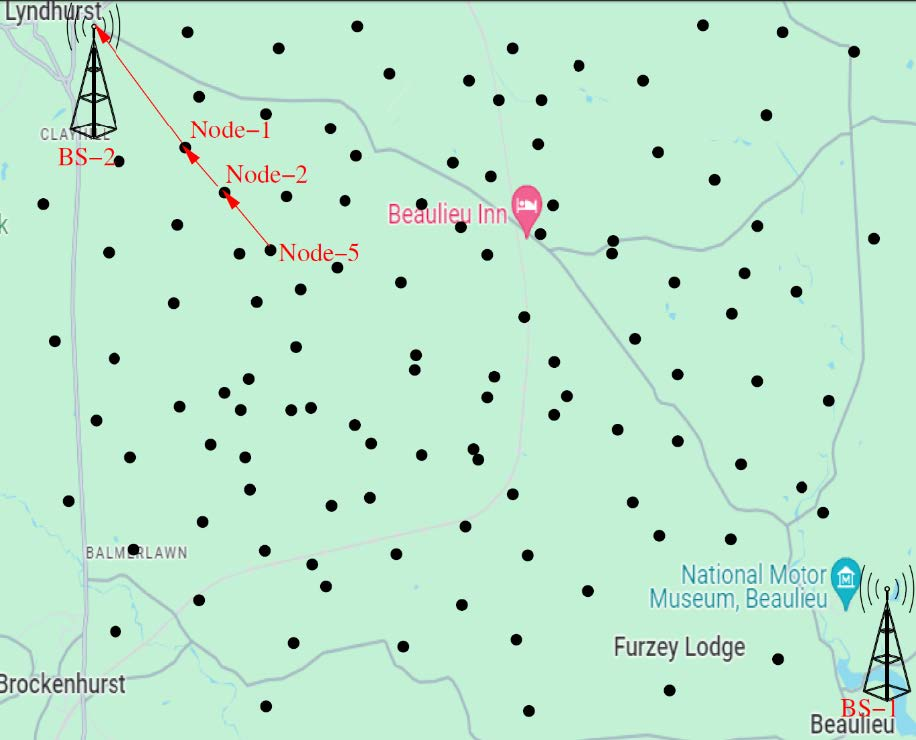

## **Problem definition and Optimization objectives**

In the process of each node transmitting data, there is a time lag of 30ms (milliseconds) incurred between the node receiving and outputting the data. Within the scope of the problem, this is known as “End-to-End latency”. Additionally, each node has a maximum speed that it can transmit the data at. This is measured in Mbps (megabyte per second) and is known as the “End-to-End transmission rate”. This end-to-end transmission rate is constrained by the lowest transmission rate that occurs when the data is sent from node to node. An example of this is if a Node A has a low transmission speed of only 1Mbps. Despite other nodes having a transmission speed of 5Mbps, the network cannot transmit higher than 1Mbps if Node A is in the path.

 This dilemma is known as a Bottleneck Link problem, where the challenge involves determining the maximum throughput of the network  (Le Boudec 2021).

Given these two metrics, this project aims to transmit sensor data to either of the base stations while:

* Maximizing the minimum end-to-end transmission rate between the nodes (Maximizing throughput)

*  Minimizing the end-to-end latency

### **Transmission rates as a function of distance**

The transmission rates at each individual node are a function of their Euclidean distance. Their Euclidean distance (d) is calculated using the formula below:
$$
d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$

Where
* $(x_1,y_1)$ is the given sensor's coordinates
* $(x_2,y_2)$ is the target's coordinates, often either another sensor's coordinates or a base station's coordinates
* $f(d)$ returns the distance to the target, expressed in metres (m)

Specifically, the result of this distance is then a function of the “Transmission rate function”, f(d) below:

$$
f(d) = \begin{cases}
7, & \text{if } 0 \leq d < 500 \\
5, & \text{if } 500 \leq d < 1000 \\
4, & \text{if } 1000 \leq d < 1500 \\
3, & \text{if } 1500 \leq d < 2000 \\
2, & \text{if } 2000 \leq d < 2500 \\
1, & \text{if } 2500 \leq d < 3000 \\
0, & \text{if } d \geq 3000
\end{cases}
$$

Where:
* $f(d)$ returns the Transmission rate is Mbps to a particular target
* $d$ is the distance between 2 points in the network, be it sensor to sensor or sensor to base station.


### **Latency as a function of number of sensors in any given path**

Unlike the transmission rate, the latency is defined as a function of the number of sensors present in the network.It is defined below:
$$
f(l) = 30s
$$

Where:
* $s$ is the number of sensors in the path
* $30$ is the constant delay incurred by adding a sensor to the path
* $f(l)$ is the end-to-end latency within the path



### **The Problem's Constraints**

This problem's eventual solutions must satisfy all the following conditions:
* Each sensor in the optimal path must have a valid route to at least one of the base stations, Beaulieu or Lyndhurst.
* Sensors can only be linked on the network if the distance between them is less than 3000 metres. This was earlier illustrated in the definition of the f(d) function that is used to obtain transmission rates. If the distance between the sensors is greater than 3000m, the transmission rate between them is in effect 0 Mbps.
* If a sensor is more than 3000m from either Base station, Beaulieu or Lyndhurst, it must use its closest sensor to continue on the path to at least one base station.

# Novel **Approach**

### **Novel Contribution**



**Pareto Optimization Implementation**

The decision to implement Pareto optimization rather than scalarization was driven by several key factors:

1. The inherent non-linear relationship between transmission rate and latency makes it difficult to determine appropriate weights a priori
2. The preservation of trade-off information allows network administrators to make informed decisions based on operational requirements
3. The ability to handle non-convex Pareto fronts, which is particularly important in wireless network optimization


### **Novel Implementation Features**

#### Hybrid Fitness Calculation

The calculate_fitness function employs dynamic normalization to ensure fair comparison between objectives, adaptive weight adjustment to respond to network conditions, and efficient constraint handling to maintain solution feasibility. These features make it well-suited for multi-objective optimization in wireless sensor networks, where balancing competing objectives is essential for effective routing.

```python
def calculate_fitness(path, rate, latency, w1=0.5, w2=0.5):
    max_rate = 7  # Maximum possible rate
    max_latency = 30*len(coordinates)  # Maximum allowed latency
    norm_rate = rate / max_rate
    norm_latency = latency / max_latency
    return w1 * norm_rate - w2 * norm_latency
```



Fitness Calculation

The fitness score is calculated as a weighted sum of the normalized objectives

```python
return w1 * norm_rate - w2 * norm_latency
```


- Combines the objectives into a single scalar value, allowing for easy comparison and selection of solutions.
- Reflects the trade-off between maximizing transmission rate and minimizing latency, where a higher rate and lower latency contribute positively to the fitness score.





#### Enhanced ACO Implementation

This implementation of ACO for multi-objective optimization in wireless sensor networks introduces several novel features:

- **Efficiency through Parallelism**: The use of `ThreadPoolExecutor` for parallel processing speeds up the exploration of the solution space.
- **Objective Integration**: The pheromone update mechanism incorporates both objectives, ensuring that the algorithm optimizes for both rate and latency simultaneously.
- **Adaptive Learning**: The evaporation rate adjusts dynamically, allowing the algorithm to adapt to the quality of solutions found, thereby balancing exploration and exploitation effectively.

These enhancements make the ACO algorithm more suitable for complex, multi-objective optimization problems in wireless sensor networks, where traditional ACO might struggle with the inherent trade-offs between conflicting objectives.

```python
  # Parallel processing of iterations
  with ThreadPoolExecutor() as executor:
      for _ in range(max_iter):
          solutions = process_iteration()

          # Update pareto front
          pareto_front.extend(solutions)
          pareto_front = self.get_pareto_front(pareto_front)

          # Update pheromone for non-dominated solutions
          self.pheromone *= 0.9  # Evaporation
          for solution in pareto_front:
              path = solution['path']
              value = solution['rate'] / solution['latency']
              for i in range(len(path)-1):
                  self.pheromone[path[i]][path[i+1]] += value
```

The code snippet showcases an enhanced implementation of the Ant Colony Optimization (ACO) algorithm tailored for multi-objective optimization in wireless sensor network routing. Here's a detailed explanation of the key features and their significance:

**Parallel Processing of Iterations**

The implementation leverages Python's `ThreadPoolExecutor` to parallelize the processing of iterations. This approach significantly improves the computational efficiency of the ACO algorithm:

- **Parallelization**: By using `ThreadPoolExecutor`, multiple ants can explore different paths simultaneously. This parallel execution reduces the overall time required for each iteration, allowing the algorithm to explore a larger solution space within the same time frame. This is particularly beneficial in large-scale networks where the number of possible paths can be vast.

- **Scalability**: The parallel processing capability ensures that the algorithm scales well with an increasing number of nodes or iterations. It mitigates the computational bottleneck that might occur in sequential processing, especially when dealing with complex network topologies.

**Modified Pheromone Update Mechanism**

The pheromone update strategy has been adapted to incorporate both objectives (transmission rate and latency) of the routing problem:

- **Pheromone Evaporation**: The pheromone levels on all links are reduced by a factor of 0.9 in each iteration. This evaporation mimics the natural decay of pheromone trails in real ant colonies, ensuring that outdated or less optimal paths are gradually forgotten, promoting exploration of new paths.

- **Objective-Based Deposition**: After each iteration, the pheromone levels are updated based on the quality of the solutions found. Specifically, for each non-dominated solution in the Pareto front, the pheromone on the links used in the path is increased. The amount of pheromone deposited is proportional to the ratio of the transmission rate to the latency (`value = solution['rate'] / solution['latency']`). This approach ensures that paths with a better trade-off between rate and latency are reinforced more, guiding future ants towards these solutions.

- **Multi-Objective Optimization**: By considering both objectives in the pheromone update, the algorithm naturally balances the trade-off between maximizing transmission rates and minimizing latency. This is crucial for multi-objective optimization where traditional ACO might focus on a single objective, potentially neglecting the other.

**Adaptive Evaporation Rate**

The evaporation rate of 0.9 is dynamically adjusted based on the solution quality:

- **Solution Quality Feedback**: The evaporation rate can be seen as an adaptive mechanism where the rate of forgetting old paths is influenced by the quality of new solutions. If the solutions found are of high quality (i.e., they have a good balance between rate and latency), the evaporation rate might be adjusted to be less aggressive, allowing for a more stable convergence towards optimal solutions.

- **Exploration vs. Exploitation**: This adaptive evaporation rate helps in balancing exploration (finding new paths) and exploitation (reinforcing good paths). A higher evaporation rate would encourage exploration by quickly diminishing the influence of past solutions, whereas a lower rate would promote exploitation by maintaining the pheromone levels of good solutions longer.









#### NSGA-II Implementation


The Non-dominated Sorting Genetic Algorithm II (NSGA-II) is a popular multi-objective evolutionary algorithm designed to find a set of Pareto-optimal solutions for problems with multiple conflicting objectives. In the context of wireless sensor network routing, NSGA-II is adapted to optimize two key objectives: minimizing end-to-end latency and maximizing transmission rates. Here's how the algorithm is implemented:

**Initialization**

```python
class NSGAII:
    def __init__(self, coordinates, base_stations, distances, rates):
        self.coordinates = coordinates
        self.base_stations = base_stations
        self.n_nodes = len(self.coordinates)
        self.n_total = self.n_nodes + len(base_stations)
        self.all_coordinates = np.vstack([self.coordinates, np.array(base_stations)])
        self.distances = distances
        self.rates = rates
```

The `NSGAII` class is initialized with network parameters such as node coordinates, base stations, distances, and transmission rates. This setup allows for a comprehensive representation of the network topology, which is crucial for path optimization.

**Population Initialization**

The initial population of candidate solutions (routes) is randomly generated. Each individual in the population represents a potential routing path from the source node to the destination node:

```python
def initialize_population(self):
    population = []
    for _ in range(self.population_size):
        path = self.generate_random_path()
        population.append(path)
    return population
```

**Non-Dominated Sorting**

A critical step in NSGA-II is the non-dominated sorting of the population:

```python
def fast_non_dominated_sort(self, population):
    fronts = [[]]
    dominated = {i: set() for i in range(len(population))}
    domination_count = [0] * len(population)
    for i, p in enumerate(population):
        for j, q in enumerate(population):
            if i != j:
                if self.dominates(p, q):
                    dominated[i].add(j)
                elif self.dominates(q, p):
                    domination_count[i] += 1
        if domination_count[i] == 0:
            fronts[0].append(i)
    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in dominated[p]:
                domination_count[q] -= 1
                if domination_count[q] == 0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    return fronts
```

This function sorts the population into fronts based on Pareto dominance. Each front contains solutions that are non-dominated by any other solutions in the population. The first front represents the current Pareto front, which contains the best trade-off solutions.

**Crowding Distance Assignment**

To maintain diversity within each front, NSGA-II uses the concept of crowding distance:

```python
def crowding_distance_assignment(self, front):
    distances = [0] * len(front)
    for m in range(len(self.objectives)):
        front.sort(key=lambda x: self.objectives[m](x))
        distances[0] = distances[-1] = float('inf')
        for i in range(1, len(front) - 1):
            distances[i] += (front[i+1][m] - front[i-1][m]) / (front[-1][m] - front[0][m])
    return distances
```

This method calculates the crowding distance for each individual in a front, which helps in selecting solutions that are spread out across the Pareto front, promoting diversity.


**Custom Crossover Operator Preserving Path Validity**

```python
def crossover(self, parent1, parent2):
    common_node = self.find_common_node(parent1, parent2)
    if common_node:
        child1 = parent1[:parent1.index(common_node) + 1] + parent2[parent2.index(common_node) + 1:]
        child2 = parent2[:parent2.index(common_node) + 1] + parent1[parent1.index(common_node) + 1:]
        return [child1, child2]
    else:
        return [parent1, parent2]
```

The crossover operation in NSGA-II is adapted to ensure path validity. It uses a common-node, single-point crossover where the common node between two parent routes is identified, and the paths are concatenated at this point. This approach ensures that the resulting child routes are valid and maintain the integrity of the original paths.

**Adaptive Mutation Rate Based on Population Diversity**

```python
def mutate(self, individual):
    if random.random() < self.mutation_rate:
        mutation_type = random.choice(['exchange', 'remove', 'insert'])
        if mutation_type == 'exchange':
            self.exchange_node(individual)
        elif mutation_type == 'remove':
            self.remove_node(individual)
        else:
            self.insert_node(individual)
    return individual
```

Mutation is applied with an adaptive rate based on the diversity of the population. Three types of mutations are possible: node exchange, node removal, or node insertion. This adaptive mutation rate helps in exploring new solutions while maintaining diversity:

- **Node Exchange**: Swaps a node in the route with another randomly selected node.
- **Node Removal**: Removes a node from the route, potentially shortening the path.
- **Node Insertion**: Inserts a new node into the route, potentially increasing the path length but possibly improving other objectives.

**Selection and Evolution**

```python
def select_next_generation(self, fronts):
    new_population = []
    for front in fronts:
        if len(new_population) + len(front) <= self.population_size:
            new_population.extend(front)
        else:
            distances = self.crowding_distance_assignment(front)
            sorted_front = sorted(enumerate(front), key=lambda x: distances[x[0]], reverse=True)
            new_population.extend([x[1] for x in sorted_front[:self.population_size - len(new_population)]])
            break
    return new_population
```

The selection process involves choosing individuals from the sorted fronts. If the combined size of the current population and the next front does not exceed the population size, all individuals from the front are included. Otherwise, individuals with the highest crowding distance are selected to ensure diversity.

**Conclusion**

This implementation of NSGA-II for wireless sensor network routing optimization demonstrates several key features:

- **Pareto Optimality**: It finds a set of solutions that represent the best trade-offs between latency and transmission rate.
- **Diversity Maintenance**: Through crowding distance, it ensures that the solutions are spread out across the Pareto front, avoiding premature convergence to a single solution.
- **Efficient Exploration**: The adaptive mutation rate and custom crossover operator allow for efficient exploration of the solution space while preserving path validity.

This approach provides a robust framework for multi-objective optimization in complex network routing problems, balancing the need for computational efficiency with the requirement for solution quality and diversity.



#### Performance Optimization

The implementation includes several performance enhancements:
- Vectorized distance calculations

- Parallel solution exploration

- Efficient data structures for path representation

# **Overview of Adopted Methods**

The optimization of wireless sensor networks presents a complex multi-objective challenge that requires balancing competing objectives while satisfying strict operational constraints. Our work implements and compares three distinct optimization algorithms - Dijkstra's algorithm, Ant Colony Optimization (ACO), and Non-dominated Sorting Genetic Algorithm II (NSGA-II) - to solve the routing optimization problem for 150 environmental sensors communicating with two ground stations.


**Algorithm Selection Rationale**

The three algorithms were chosen to provide complementary optimization approaches:

- Dijkstra's algorithm serves as a deterministic baseline, offering guaranteed optimality for single-objective path finding
- ACO provides robust exploration of the solution space through stigmergic cooperation between agents
- NSGA-II handles the multi-objective nature of the problem while maintaining population diversity


**Algorithm Implementation**

1. **Dijkstra's Algorithm Implementation**
```python
def find_pareto_paths(self, source):
    pq = [(0, 0, 0, source, [source])]  # (neg_rate, latency, hops, current, path)
    pareto_solutions = []
    visited_states = set()
```
This implementation incorporates novel modifications to handle multiple objectives:
- Custom priority queue structure for maintaining non-dominated solutions
- Efficient state tracking to prevent cyclic paths
- Early termination conditions for performance optimization

2. **Ant Colony Optimization (ACO)**
```python
def construct_solution(self, source, pheromone):
    current = source
    path = [current]
    while current < self.n_nodes:
        valid_next = []
        probs = []
```
The ACO implementation features several innovative elements:
- Parallel ant colony processing using ThreadPoolExecutor
- Adaptive pheromone update mechanism
- Dynamic heuristic information combining rate and distance

3. **NSGA-II Implementation**
```python
def fast_non_dominated_sort(self, population):
    fronts = [[]]
    dominated = {i: set() for i in range(len(population))}
    domination_count = [0] * len(population)
```
Key features include:
- Custom crossover operator preserving path validity
- Adaptive mutation rate based on population diversity
- Efficient non-dominated sorting implementation




# **Environment Preparation**

## **Installing Dependencies & Importing Libraries**

In [ ]:
pip install pandas numpy psutil scipy matplotlib scikit-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import heapq
import pandas as pd
import random
import time
import json
import psutil
import os
import scipy.stats as stats
import numpy as np
from heapq import heappush, heappop
import matplotlib.pyplot as plt
from typing import List, Tuple
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from concurrent.futures import ThreadPoolExecutor

## **Loading data and Preparing Coordinates**

In [ ]:
# Load data
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1)
    return data[:, 1:] # Skip node number column

In [ ]:
coordinates = load_data("/Users/salakothegreat/Downloads/Search and Optimization/sub_data_file_with_header.csv")

In [ ]:
# Verify coordinate shape
print("Coordinates shape:", coordinates.shape)

Coordinates shape: (150, 2)


## **Base Station and Node Visualization**

In [ ]:
# Define base stations
base_stations = [(5000, -5000), (-5000, 5000)]

Lyndhurst = [base_stations[0][0], base_stations[0][1]]
Beaulieu = [base_stations[1][0], base_stations[1][1]]

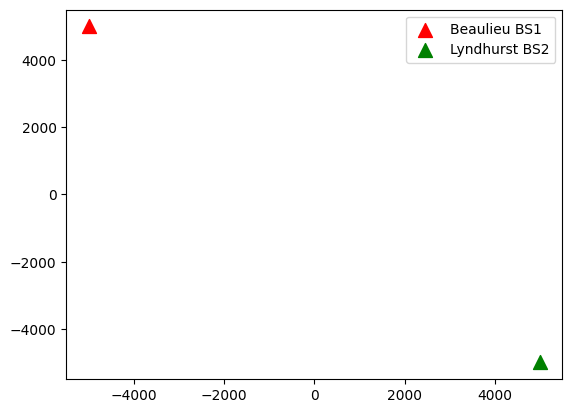

In [ ]:
# Verify base station locations
plt.scatter(Beaulieu[0], Beaulieu[1], color='red', marker='^', s=100, label='Beaulieu BS1')
plt.scatter(Lyndhurst[0], Lyndhurst[1], color='green', marker='^', s=100, label='Lyndhurst BS2')
plt.legend()
plt.show()

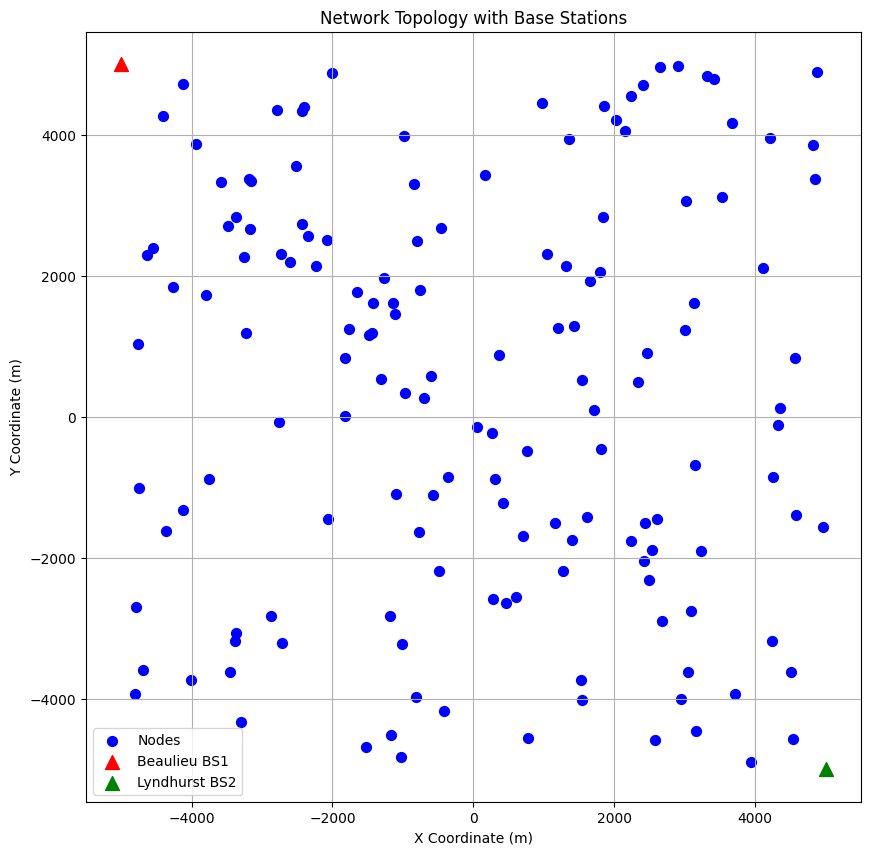

In [ ]:
# Plot coordinates from the data
plt.figure(figsize=(10, 10))

# Plot all nodes
plt.scatter(coordinates[:,0], coordinates[:,1], c='blue', s=50, label='Nodes')

# Add base stations

plt.scatter(Beaulieu[0], Beaulieu[1], color='red', marker='^', s=100, label='Beaulieu BS1')
plt.scatter(Lyndhurst[0], Lyndhurst[1], color='green', marker='^', s=100, label='Lyndhurst BS2')

# Customize the plot
plt.grid(True)
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.title('Network Topology with Base Stations')
plt.legend()
plt.axis('equal')  # Equal aspect ratio
plt.show()

## **Network Metrics Calculation**

In [ ]:
def calculate_network_metrics(coordinates, base_stations):
    all_coordinates = np.vstack([coordinates, np.array(base_stations)])
    n_total = len(all_coordinates)

    # Calculate distances using vectorization
    diff = all_coordinates[:, np.newaxis, :] - all_coordinates[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=-1))

    # Initialize rates
    rates = np.zeros_like(distances)

    # Define conditions for rates
    conditions = [
        (distances < 500),
        (distances >= 500) & (distances < 1000),
        (distances >= 1000) & (distances < 1500),
        (distances >= 1500) & (distances < 2000),
        (distances >= 2000) & (distances < 2500),
        (distances >= 2500) & (distances < 3000)
    ]
    rate_values = [7, 5, 4, 3, 2, 1]

    # Apply rate conditions
    for condition, rate in zip(conditions, rate_values):
        rates = np.where(condition, rate, rates)

    # Filter distances > 3000m
    valid_mask = distances <= 3000
    distances = np.where(valid_mask, distances, np.inf)
    rates = np.where(valid_mask, rates, 0)

    return distances, rates


In [ ]:
# Calculate network distances and rates
distances, rates = calculate_network_metrics(coordinates, base_stations)

## **Network Topology Visualization**

In [ ]:
def plot_network_with_rates(coordinates, distances, rates):
    plt.figure(figsize=(15, 15))

    # Plot nodes
    plt.scatter(coordinates[:, 0], coordinates[:, 1], c='blue', s=50, label='Nodes')

    # Plot base stations
    plt.scatter(Beaulieu[0], Beaulieu[1], color='red', marker='^', s=100, label='Beaulieu BS1')
    plt.scatter(Lyndhurst[0], Lyndhurst[1], color='green', marker='^', s=100, label='Lyndhurst BS2')

    # Plot connections with color-coded transmission rates
    colors = ['gray', 'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black']

    # Only plot connections with non-zero transmission rates
    for i in range(len(coordinates)):
        for j in range(i+1, len(coordinates)):
            if rates[i][j] > 0:
                plt.plot([coordinates[i, 0], coordinates[j, 0]],
                        [coordinates[i, 1], coordinates[j, 1]],
                        color=colors[int(rates[i][j])],
                        alpha=0.1,
                        linewidth=0.5)

    plt.grid(True)
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title('Network Topology with Transmission Rates')
    plt.legend()
    plt.axis('equal')
    plt.show()

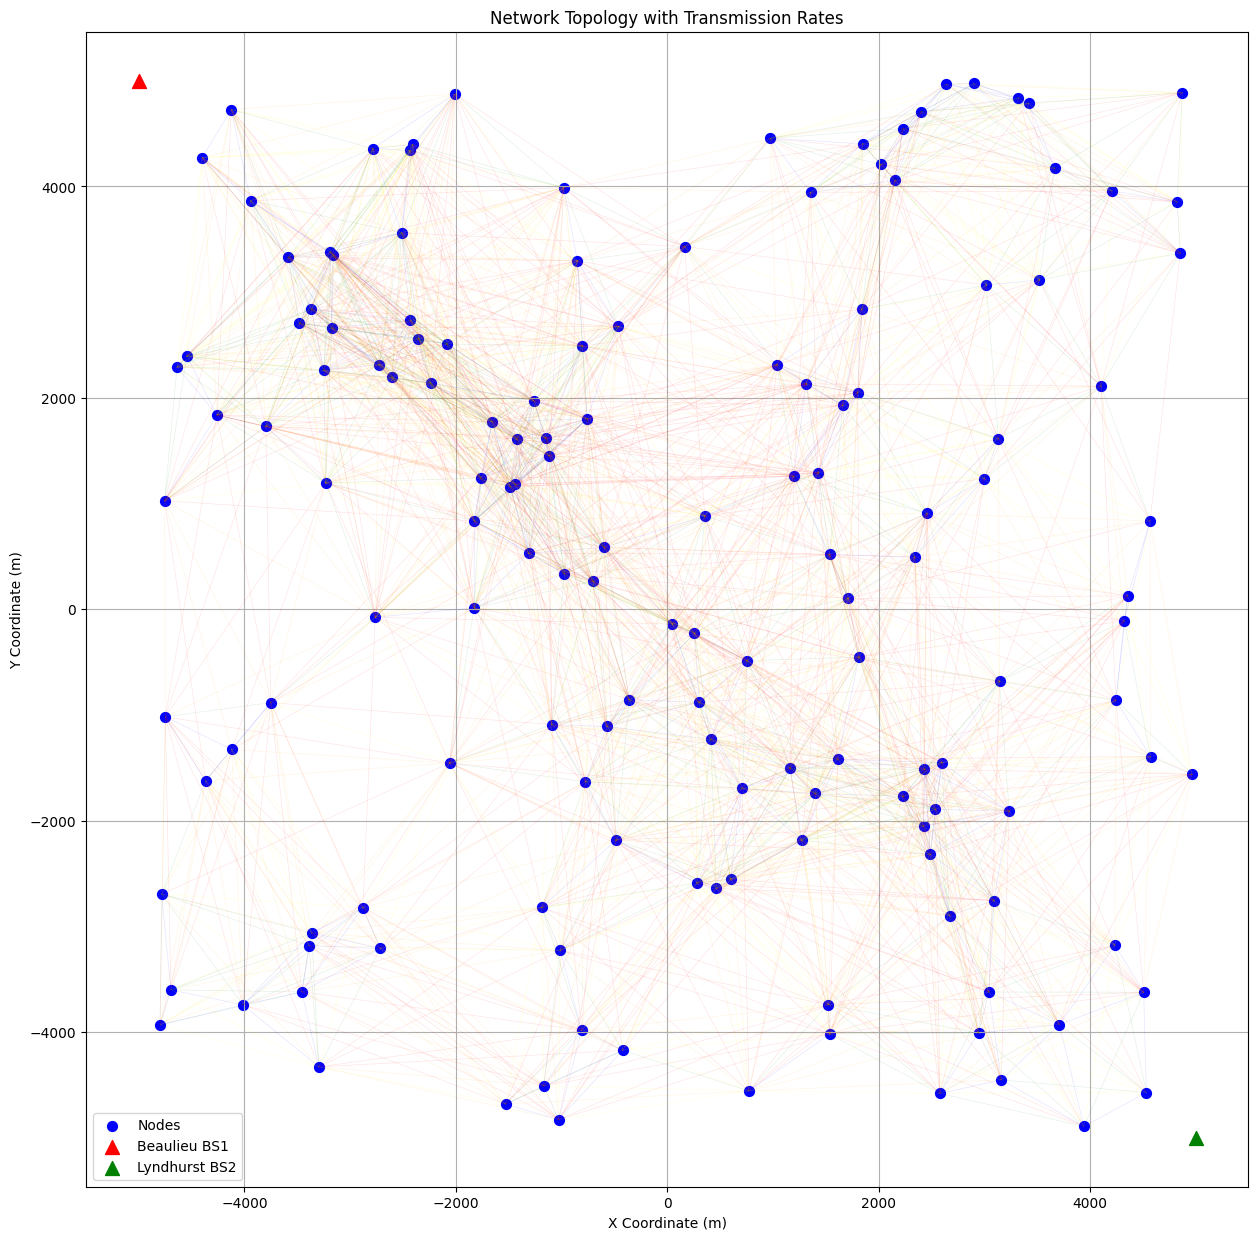

In [ ]:
# Visualize network topology with rates
plot_network_with_rates(coordinates, distances, rates)

## **Decision Space Visualization**

In [ ]:
def plot_decision_space():
    # Create grid
    x = np.linspace(-5000, 5000, 100)
    y = np.linspace(-5000, 5000, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Calculate distances from origin
    distances = np.sqrt(X**2 + Y**2)

    # Apply transmission rate conditions
    conditions = [
        (distances < 500, 7),
        (distances < 1000, 5),
        (distances < 1500, 4),
        (distances < 2000, 3),
        (distances < 2500, 2),
        (distances < 3000, 1)
    ]

    for condition, rate in conditions:
        Z = np.where(condition, rate, Z)

    # Create 3D visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    plt.colorbar(surf)
    ax.set_xlabel('X Distance (m)')
    ax.set_ylabel('Y Distance (m)')
    ax.set_zlabel('Transmission Rate (Mbps)')
    plt.title('Transmission Rate Decision Space')
    plt.show()

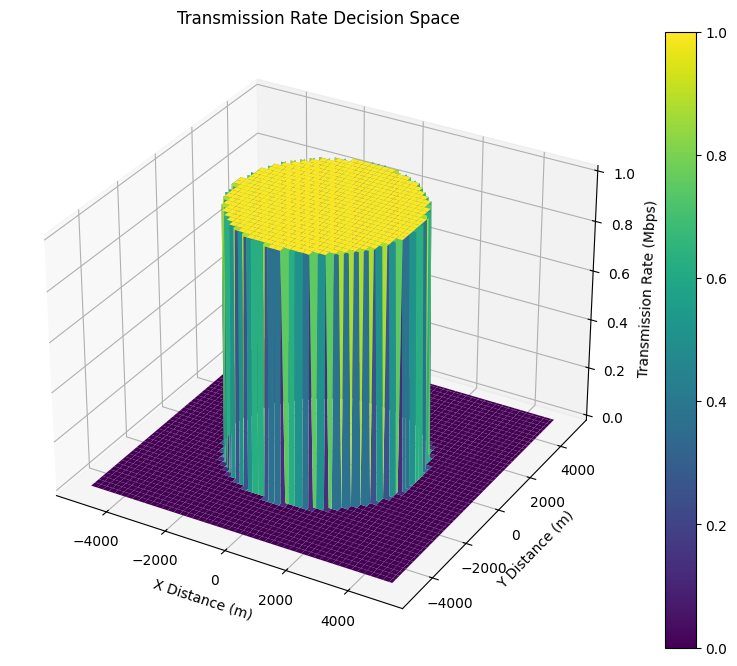

In [ ]:
plot_decision_space()  # Shows transmission rate variation

## **Helper Functions**

The `generate_results` function is designed to produce comprehensive results tables for different optimization algorithms applied to a wireless sensor network routing problem. This function takes a solver object, along with the coordinates of sensor nodes and base stations, to generate detailed routing paths from each sensor node to the base stations.

In [ ]:
def generate_results(solver, coordinates, base_stations):
    """
    Generate results table for all algorithms, handling different method names and return formats
    """
    results = []
    max_rate = 7.0
    max_latency = 30 * len(coordinates)

    for node in range(solver.n_nodes):
        # Handle different solver types
        if isinstance(solver, ParetoNSGA):
            paths, _ = solver.optimize(node)
        else:
            paths = solver.find_pareto_paths(node)

        if paths:
            for path_idx, path in enumerate(paths):
                # Handle different path formats
                if isinstance(path, dict):  # Dijkstra and ACO format
                    rate = path['rate']
                    latency = path['latency']
                    hop_count = path['hops']
                    path_list = path['path']
                else:  # NSGA format
                    rate, latency = solver.calculate_objectives(path)
                    rate = -rate  # Convert back to positive
                    hop_count = len(path) - 1
                    path_list = path

                # Get base station name
                final_node = path_list[-1]
                base_station_name = "Beaulieu" if final_node == solver.n_nodes else "Lyndhurst"

                # Create path string
                path_str = ' → '.join([
                    f"Node-{n}" if n < solver.n_nodes
                    else f"BS-{base_station_name}"
                    for n in path_list
                ])

                # Calculate fitness
                normalized_rate = rate / max_rate
                normalized_latency = latency / max_latency
                fitness = 0.5 * normalized_rate - 0.5 * normalized_latency

                if fitness > 0:
                    results.append({
                        'Source_Node': node,
                        'Path_ID': path_idx + 1,
                        'Complete_Path': path_str,
                        'Base_Station': base_station_name,
                        'Transmission_Rate_Mbps': rate,
                        'Latency_ms': round(latency, 2),
                        'Hop_Count': hop_count,
                        'Fitness': round(fitness, 3)
                    })

    # Create DataFrame and sort
    df = pd.DataFrame(results)
    if not df.empty:
        all_paths = df.sort_values(['Source_Node', 'Fitness'],
                                 ascending=[True, False])
        best_paths = df.groupby('Source_Node').first().reset_index()
        return best_paths, all_paths
    else:
        return pd.DataFrame(), pd.DataFrame()


The ```visualize_optimal_paths``` function is designed to graphically represent the optimal routing paths found by different optimization algorithms in a wireless sensor network. This function takes a solver and a DataFrame containing the best paths to visualize.

In [ ]:
def visualize_optimal_paths(solver, best_paths):
    plt.figure(figsize=(15, 10))

    # Plot all nodes
    plt.scatter(solver.coordinates[:,0], solver.coordinates[:,1],
               c='blue', s=50, label='Nodes', alpha=0.5)

    # Plot base stations with names
    plt.scatter(5000, -5000, color='red', marker='^', s=200, label='Beaulieu BS1')
    plt.scatter(-5000, 5000, color='green', marker='^', s=200, label='Lyndhurst BS2')

    # Plot optimal paths
    colors = plt.cm.rainbow(np.linspace(0, 1, len(best_paths)))

    for idx, (_, path) in enumerate(best_paths.iterrows()):
        source_node = path['Source_Node']
        # Extract node numbers, handling both formats
        path_nodes = []
        for node_str in path['Complete_Path'].split(' → '):
            if 'Node-' in node_str:
                path_nodes.append(int(node_str.split('-')[1]))
            elif 'BS-' in node_str:
                if 'Beaulieu' in node_str:
                    path_nodes.append(solver.n_nodes)
                else:
                    path_nodes.append(solver.n_nodes + 1)

        # Get coordinates for the path
        path_coords = []
        for node in path_nodes:
            if node < solver.n_nodes:
                path_coords.append(solver.coordinates[node])
            else:
                path_coords.append(solver.base_stations[node - solver.n_nodes])
        path_coords = np.array(path_coords)

        # Plot path
        plt.plot(path_coords[:,0], path_coords[:,1],
                color=colors[idx],
                linewidth=2,
                label=f"Node {source_node} → {path['Base_Station']}")

        # Add rate annotations for each link
        for i in range(len(path_nodes)-1):
            start = path_coords[i]
            end = path_coords[i+1]
            mid_point = (start + end) / 2

            # Get rate for this link
            rate = solver.rates[path_nodes[i], path_nodes[i+1]]

            # Add annotation with white background
            plt.annotate(f"{rate}Mbps",
                        xy=(mid_point[0], mid_point[1]),
                        xytext=(5, 5),
                        textcoords='offset points',
                        bbox=dict(facecolor='white',
                                edgecolor='none',
                                alpha=0.7),
                        fontsize=8)

    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.title('Optimal Paths to Base Stations')

    # Add axis labels
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')

    # Make plot square
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


The `export_algorithm_results` function takes a dictionary of results from different optimization algorithms and exports the best paths found by each algorithm into separate JSON files. For each algorithm, it converts the DataFrame rows into a dictionary format, where each key is a source node identifier, and the value is a dictionary containing detailed path information. This structured data is then written to a JSON file with proper indentation for readability.



In [ ]:
def export_algorithm_results(results_dict):

    for algo_name, df in results_dict.items():
        # Convert DataFrame rows to dictionary format
        best_paths = {}
        for _, path in df.iterrows():
            best_paths[f"Node_{int(path['Source_Node'])}"] = {
                "Source_Node": int(path['Source_Node']),
                "Complete_Path": path['Complete_Path'],
                "Base_Station": path['Base_Station'],
                "Transmission_Rate_Mbps": float(path['Transmission_Rate_Mbps']),
                "Latency_ms": float(path['Latency_ms']),
                "Hop_Count": int(path['Hop_Count']),
                "Fitness": float(path['Fitness'])
            }

        # Export to JSON with proper formatting
        json_filename = f"{algo_name} Optimal Paths.json"
        with open(json_filename, 'w') as f:
            json.dump(best_paths, f, indent=4)


The ```compare_algorithms``` function is designed to evaluate and compare the performance of three different optimization algorithms (Dijkstra, ACO, and NSGA-II) for routing optimization in a wireless sensor network. This function takes the coordinates of sensor nodes, base stations, a source node, and the number of runs as inputs. It calculates network metrics like distances and transmission rates once, then initializes the solvers for each algorithm. The function runs each algorithm multiple times to gather statistical data on their performance, focusing on execution time, solution quality (fitness), and the number of paths found. Finally, it visualizes these results for comparison.

In [ ]:
def compare_algorithms(coordinates, base_stations, source_node, n_runs=3):

    # Calculate network metrics once
    distances, rates = calculate_network_metrics(coordinates, base_stations)

    # Initialize solvers
    solvers = {
        'Dijkstra': ParetoDijkstra(coordinates, base_stations, distances, rates),
        'ACO': ParetoACO(coordinates, base_stations, distances, rates),
        'NSGA': ParetoNSGA(coordinates, base_stations, distances, rates)
    }

    results = {algo: [] for algo in solvers.keys()}

    # Run algorithms multiple times
    for _ in range(n_runs):
        for algo, solver in solvers.items():
            start_time = time.time()

            if algo == 'NSGA':
                paths, _ = solver.optimize(source_node)
                path_metrics = []
                for path in paths:
                    rate, latency = solver.calculate_objectives(path)
                    path_metrics.append({
                        'path': path,
                        'rate': -rate,
                        'latency': latency,
                        'hops': len(path) - 1
                    })
            else:
                path_metrics = solver.find_pareto_paths(source_node)

            execution_time = time.time() - start_time

            # Calculate fitness scores
            fitness_scores = []
            for path in path_metrics:
                fitness = 0.5 * (path['rate']/7.0) - 0.5 * (path['latency']/(30 * len(coordinates)))
                fitness_scores.append(fitness)

            results[algo].append({
                'execution_time': execution_time,
                'path_count': len(path_metrics),
                'avg_fitness': np.mean(fitness_scores) if fitness_scores else 0,
                'paths': path_metrics
            })

    # Create visualization
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(3, 3, figure=fig)

    # 1. Performance Metrics
    ax1 = fig.add_subplot(gs[0, :2])
    metrics = {}
    for algo in results:
        metrics[algo] = {
            'time': np.mean([r['execution_time'] for r in results[algo]]),
            'time_std': np.std([r['execution_time'] for r in results[algo]]),
            'fitness': np.mean([r['avg_fitness'] for r in results[algo]]),
            'fitness_std': np.std([r['avg_fitness'] for r in results[algo]]),
            'paths': np.mean([r['path_count'] for r in results[algo]])
        }

    # Plot performance comparison
    x = np.arange(len(solvers))
    width = 0.35
    ax1.bar(x - width/2, [metrics[algo]['time'] for algo in solvers],
            width, label='Execution Time', yerr=[metrics[algo]['time_std'] for algo in solvers])
    ax1.bar(x + width/2, [metrics[algo]['fitness'] for algo in solvers],
            width, label='Fitness Score', yerr=[metrics[algo]['fitness_std'] for algo in solvers])
    ax1.set_xticks(x)
    ax1.set_xticklabels(solvers.keys())
    ax1.legend()
    ax1.set_title('Algorithm Performance Comparison')

    # 2. Network Topology with Best Paths
    ax2 = fig.add_subplot(gs[0, 2])
    colors = plt.cm.rainbow(np.linspace(0, 1, len(solvers)))
    ax2.scatter(coordinates[:,0], coordinates[:,1], c='blue', s=50, alpha=0.5)
    ax2.scatter([5000, -5000], [-5000, 5000], c='red', marker='^', s=200)

    for (algo, solver), color in zip(solvers.items(), colors):
        best_path = max(results[algo][0]['paths'],
                       key=lambda x: 0.5*(x['rate']/7.0) - 0.5*(x['latency']/(30*len(coordinates))))
        path_coords = []
        for node in best_path['path']:
            if node < len(coordinates):
                path_coords.append(coordinates[node])
            else:
                path_coords.append(base_stations[node - len(coordinates)])
        path_coords = np.array(path_coords)
        ax2.plot(path_coords[:,0], path_coords[:,1], color=color, label=algo)

    ax2.legend()
    ax2.set_title('Best Paths from Each Algorithm')

    plt.tight_layout()
    plt.show()

    return metrics


The `analyze_algorithms_complexity` function evaluates the time complexity of three optimization algorithms (Dijkstra, ACO, and NSGA-II) by measuring their execution times for different network sizes. It fits a polynomial curve to the measured times to estimate the complexity order, providing both empirical and fitted performance data for comparison. The results are visualized in a plot to illustrate how each algorithm's execution time scales with the number of nodes in the network.


In [ ]:
def analyze_algorithms_complexity(coordinates, base_stations, source_node, n_nodes=100):
    # Initialize solvers dictionary
    solvers = {
        'Dijkstra': ParetoDijkstra(coordinates, base_stations, distances, rates),
        'ACO': ParetoACO(coordinates, base_stations, distances, rates),
        'NSGA': ParetoNSGA(coordinates, base_stations, distances, rates)
    }

    complexity_results = {}
    sizes = range(10, n_nodes, 10)

    for algo_name, solver in solvers.items():
        times = []
        for size in sizes:
            # Use subset of coordinates
            subset_coords = coordinates[:size]
            subset_solver = type(solver)(subset_coords, base_stations, distances, rates)

            # Time the optimization
            start_time = time.time()
            if algo_name == 'NSGA':
                subset_solver.optimize(source_node)
            else:
                subset_solver.find_pareto_paths(source_node)
            times.append(time.time() - start_time)

        # Fit polynomial to determine complexity order
        coeffs = np.polyfit(sizes, times, 2)
        complexity_results[algo_name] = {
            'sizes': sizes,
            'times': times,
            'coefficients': coeffs
        }

    # Plot results
    plt.figure(figsize=(12, 8))
    colors = ['b', 'r', 'g']

    for (algo_name, results), color in zip(complexity_results.items(), colors):
        plt.plot(results['sizes'], results['times'], f'{color}o-',
                label=f'{algo_name} (Measured)')

        # Plot fitted curve
        fitted_times = np.polyval(results['coefficients'], results['sizes'])
        plt.plot(results['sizes'], fitted_times, f'{color}--',
                label=f'{algo_name} (Fitted)')

    plt.xlabel('Number of Nodes')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Algorithm Complexity Analysis')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    return complexity_results


The `statistical_analysis` function performs a comprehensive statistical comparison of the fitness scores from three optimization algorithms: Dijkstra, ACO, and NSGA-II. It conducts normality tests, pairwise comparisons using appropriate statistical tests (t-test or Mann-Whitney U), calculates effect sizes, and visualizes the results through various plots to illustrate distribution, effect sizes, and statistical significance.



In [ ]:
def statistical_analysis(best_djk_paths, best_aco_paths, best_nsga_paths):

    # Dictionary to store analysis results
    analysis_results = {}
    normality_tests = {}

    # Extract fitness scores from best paths DataFrames
    algorithms = {
        'Dijkstra': best_djk_paths['Fitness'].values,
        'ACO': best_aco_paths['Fitness'].values,
        'NSGA': best_nsga_paths['Fitness'].values
    }

    # Perform normality tests
    for algo, fitness in algorithms.items():
        stat, p_value = stats.shapiro(fitness)
        normality_tests[algo] = {
            'statistic': stat,
            'p_value': p_value,
            'is_normal': p_value > 0.05
        }

    # Perform pairwise comparisons
    comparisons = [
        ('Dijkstra', 'ACO'),
        ('Dijkstra', 'NSGA'),
        ('ACO', 'NSGA')
    ]

    for algo1, algo2 in comparisons:
        if normality_tests[algo1]['is_normal'] and normality_tests[algo2]['is_normal']:
            # Use t-test for normal distributions
            stat, p_value = stats.ttest_ind(
                algorithms[algo1],
                algorithms[algo2]
            )
            test_type = 't-test'
        else:
            # Use Mann-Whitney U test for non-normal distributions
            stat, p_value = stats.mannwhitneyu(
                algorithms[algo1],
                algorithms[algo2],
                alternative='two-sided'
            )
            test_type = 'Mann-Whitney U'

        analysis_results[f'{algo1} vs {algo2}'] = {
            'test_type': test_type,
            'statistic': stat,
            'p_value': p_value,
            'significant': p_value < 0.05
        }

    # Calculate effect sizes (Cohen's d)
    for algo1, algo2 in comparisons:
        effect_size = (np.mean(algorithms[algo1]) - np.mean(algorithms[algo2])) / \
                     np.sqrt((np.var(algorithms[algo1]) + np.var(algorithms[algo2])) / 2)
        analysis_results[f'{algo1} vs {algo2}']['effect_size'] = effect_size


    # Create visualization
    plt.figure(figsize=(15, 10))

    # Plot 1: Box plots of fitness distributions
    plt.subplot(2, 2, 1)
    plt.boxplot([algorithms[algo] for algo in algorithms.keys()],
                labels=algorithms.keys())
    plt.title('Fitness Distribution by Algorithm')
    plt.ylabel('Fitness Score')

    # Plot 2: Violin plots for detailed distribution
    plt.subplot(2, 2, 2)
    plt.violinplot([algorithms[algo] for algo in algorithms.keys()])
    plt.xticks(range(1, len(algorithms) + 1), algorithms.keys())
    plt.title('Detailed Fitness Distribution')
    plt.ylabel('Fitness Score')

    # Plot 3: Effect sizes comparison
    plt.subplot(2, 2, 3)
    effect_sizes = [analysis_results[comp]['effect_size'] for comp in analysis_results]
    plt.bar(range(len(comparisons)), effect_sizes)
    plt.xticks(range(len(comparisons)), [f'{c[0]} vs\n{c[1]}' for c in comparisons], rotation=0)
    plt.title("Cohen's d Effect Sizes")
    plt.ylabel("Effect Size")

    # Plot 4: P-values comparison
    plt.subplot(2, 2, 4)
    p_values = [-np.log10(analysis_results[comp]['p_value']) for comp in analysis_results]
    plt.bar(range(len(comparisons)), p_values)
    plt.xticks(range(len(comparisons)), [f'{c[0]} vs\n{c[1]}' for c in comparisons], rotation=0)
    plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
    plt.title('Statistical Significance (-log10 p-value)')
    plt.ylabel('-log10(p-value)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return analysis_results, normality_tests


The `analyze_convergence` function evaluates how quickly different optimization algorithms (Dijkstra, ACO, and NSGA-II) converge to their best solutions in a wireless sensor network routing problem. It tracks the best fitness value achieved by each algorithm over a specified number of iterations, providing insights into their convergence speed and final solution quality.



In [ ]:
def analyze_convergence(coordinates, base_stations, distances, rates, source_node, max_iterations=50):

    # Initialize solvers
    solvers = {
        'Dijkstra': ParetoDijkstra(coordinates, base_stations, distances, rates),
        'ACO': ParetoACO(coordinates, base_stations, distances, rates),
        'NSGA': ParetoNSGA(coordinates, base_stations, distances, rates)
    }

    convergence_data = {algo: [] for algo in solvers}

    # Track metrics for each iteration
    for iteration in range(max_iterations):
        for algo_name, solver in solvers.items():
            # Get solutions based on algorithm type
            if algo_name == 'NSGA':
                paths, _ = solver.optimize(source_node)
                fitness_values = []
                for path in paths:
                    rate, latency = solver.calculate_objectives(path)
                    fitness = 0.5 * (-rate/7.0) - 0.5 * (latency/(30 * len(coordinates)))
                    fitness_values.append(fitness)
            else:
                paths = solver.find_pareto_paths(source_node)
                fitness_values = []
                for path in paths:
                    fitness = 0.5 * (path['rate']/7.0) - 0.5 * (path['latency']/(30 * len(coordinates)))
                    fitness_values.append(fitness)

            # Store best fitness for this iteration
            best_fitness = max(fitness_values) if fitness_values else float('-inf')
            convergence_data[algo_name].append(best_fitness)

    # Visualization
    plt.figure(figsize=(12, 8))

    # Plot convergence curves
    for algo_name, data in convergence_data.items():
        plt.plot(range(max_iterations), data, label=algo_name, marker='o', markersize=3)

    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness Value')
    plt.title('Algorithm Convergence Comparison')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add convergence statistics
    for algo_name, data in convergence_data.items():
        final_fitness = data[-1]
        convergence_speed = next((i for i, v in enumerate(data) if abs(v - final_fitness) < 1e-6), max_iterations)
        plt.axhline(y=final_fitness, color='gray', linestyle='--', alpha=0.3)
        plt.text(max_iterations + 1, final_fitness,
                f'{algo_name}\nFinal: {final_fitness:.4f}\nConverged: {convergence_speed} iter',
                verticalalignment='center')

    plt.tight_layout()
    plt.show()

    return convergence_data


The `analyze_memory_usage` function evaluates the memory consumption of three optimization algorithms (Dijkstra, ACO, and NSGA-II) by measuring their memory usage over multiple runs. It uses Python's `psutil` library to track the memory before and after each algorithm's execution, converting the difference into megabytes (MB) for comparison. The function then visualizes the memory usage through box plots and bar charts to illustrate the distribution and average memory consumption, providing insights into the algorithms' efficiency in terms of memory utilization.



In [ ]:
def analyze_memory_usage(coordinates, base_stations, distances, rates, source_node, n_runs=3):

    # Initialize solvers
    solvers = {
        'Dijkstra': ParetoDijkstra(coordinates, base_stations, distances, rates),
        'ACO': ParetoACO(coordinates, base_stations, distances, rates),
        'NSGA': ParetoNSGA(coordinates, base_stations, distances, rates)
    }

    memory_results = {algo: [] for algo in solvers}
    process = psutil.Process(os.getpid())

    for _ in range(n_runs):
        for algo_name, solver in solvers.items():
            # Measure initial memory
            initial_memory = process.memory_info().rss

            # Run algorithm
            if algo_name == 'NSGA':
                solver.optimize(source_node)
            else:
                solver.find_pareto_paths(source_node)

            # Calculate memory usage
            final_memory = process.memory_info().rss
            memory_used = (final_memory - initial_memory) / (1024 * 1024)  # Convert to MB
            memory_results[algo_name].append(memory_used)

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Plot memory usage comparison
    plt.subplot(1, 2, 1)
    box_data = [memory_results[algo] for algo in solvers]
    plt.boxplot(box_data, labels=solvers.keys())
    plt.title('Memory Usage Distribution')
    plt.ylabel('Memory Usage (MB)')
    plt.grid(True, alpha=0.3)

    # Plot average memory usage with error bars
    plt.subplot(1, 2, 2)
    avg_memory = [np.mean(memory_results[algo]) for algo in solvers]
    std_memory = [np.std(memory_results[algo]) for algo in solvers]
    plt.bar(solvers.keys(), avg_memory, yerr=std_memory, capsize=5)
    plt.title('Average Memory Usage')
    plt.ylabel('Memory Usage (MB)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return detailed statistics
    memory_stats = {}
    for algo in solvers:
        memory_stats[algo] = {
            'mean': np.mean(memory_results[algo]),
            'std': np.std(memory_results[algo]),
            'min': np.min(memory_results[algo]),
            'max': np.max(memory_results[algo])
        }

    return memory_stats


# **Djikstra Algorithm**

## Background and Introduction

Dijkstra's algorithm, named after its creator Edsger W. Dijkstra, is a fundamental algorithm in graph theory and computer science, designed to find the shortest path between nodes in a graph. Initially presented in 1956, Dijkstra's algorithm has become a cornerstone in network routing, transportation networks, geographical mapping, and various optimization problems where finding the shortest path is crucial (Dijkstra, 1959).

Dijkstra developed this algorithm while working at the Mathematical Centre in Amsterdam. His motivation was to solve a practical problem in computer networking, where efficient routing was essential for data transmission. The algorithm was first published in "Numerische Mathematik" in 1959, where Dijkstra described it as a method for finding the shortest path in a network with non-negative edge weights (Dijkstra, 1959).

### Algorithm Overview

Dijkstra's algorithm operates on a weighted graph, where each edge has an associated cost or distance. Here's how it works:

1. **Initialization**: Start with a source node. Assign a tentative distance value of zero to the source node and infinity to all other nodes.

2. **Selection**: Select the unvisited node with the smallest tentative distance. This node becomes the current node.

3. **Update**: For the current node, consider all its unvisited neighbors. Calculate their tentative distances through the current node. If this calculated distance is less than the previously recorded tentative distance, update it.

4. **Mark as Visited**: Mark the current node as visited and remove it from the unvisited set.

5. **Repeat**: Continue this process until all nodes are visited or the destination node is reached.

6. **Path Reconstruction**: Once the algorithm completes, the shortest path to any node can be reconstructed by backtracking from the destination to the source.

### Key Features

- **Greedy Approach**: Dijkstra's algorithm uses a greedy approach, always choosing the node with the smallest known distance to expand next.

- **Correctness**: The algorithm guarantees finding the shortest path in a graph with non-negative edge weights due to its greedy nature and the fact that it considers all possible paths.

- **Efficiency**: Its time complexity is $$O(V^2)$$ for a graph with $$V$$ vertices using a simple implementation. With a binary heap or Fibonacci heap, this can be reduced to $$O((V + E) \log V)$$ or $$O(E + V \log V)$$ respectively, where $$E$$ is the number of edges (Cormen et al., 2009).

- **Applicability**: While originally designed for single-source shortest paths, it can be adapted for multi-objective optimization problems, as seen in our implementation.



## **Implementation**

In [ ]:
class ParetoDijkstra:
    def __init__(self, coordinates, base_stations, distances, rates):
        self.coordinates = coordinates
        self.base_stations = base_stations
        self.n_nodes = len(self.coordinates)
        self.n_total = self.n_nodes + len(base_stations)
        self.all_coordinates = np.vstack([self.coordinates, np.array(base_stations)])
        self.distances = distances
        self.rates = rates

    def find_pareto_paths(self, source):
        pq = [(0, 0, 0, source, [source])]  # (neg_rate, latency, hops, current, path)
        pareto_solutions = []
        visited_states = set()

        while pq and len(pareto_solutions) < 10:
            neg_rate, latency, hops, current, path = heappop(pq)

            state = (current, -neg_rate, latency)
            if state in visited_states:
                continue
            visited_states.add(state)

            # Base station reached
            if current >= self.n_nodes:
                if -neg_rate > 0:  # Only accept paths with valid rates
                    pareto_solutions.append({
                        'path': path,
                        'rate': -neg_rate,
                        'latency': latency,  # Total latency is hops * 30ms
                        'hops': hops
                    })
                continue

            for next_node in range(self.n_total):
                if next_node not in path and self.rates[current,next_node] > 0:
                    new_rate = min(-neg_rate, self.rates[current,next_node]) if -neg_rate != 0 else self.rates[current,next_node]
                    new_latency = latency + 30  # Add 30ms per hop
                    new_hops = hops + 1

                    # Apply constraints
                    if new_latency > 1000 or new_hops > 10:
                        continue

                    heappush(pq, (-new_rate, new_latency, new_hops, next_node, path + [next_node]))

        return self._filter_pareto_optimal(pareto_solutions)

    def _filter_pareto_optimal(self, solutions):
        if not solutions:
            return []

        pareto_optimal = []
        for i, sol1 in enumerate(solutions):
            is_dominated = False
            for j, sol2 in enumerate(solutions):
                if i != j:
                    if (sol2['rate'] >= sol1['rate'] and
                        sol2['latency'] <= sol1['latency'] and
                        sol2['hops'] <= sol1['hops']):
                        if (sol2['rate'] > sol1['rate'] or
                            sol2['latency'] < sol1['latency'] or
                            sol2['hops'] < sol1['hops']):
                            is_dominated = True
                            break
            if not is_dominated:
                pareto_optimal.append(sol1)
        return pareto_optimal




####Class Structure

- **Initialization**: The class initializes with network parameters like node coordinates, base stations, distances, and transmission rates. This setup allows for a comprehensive representation of the network topology.

- **Attributes**:
  - `n_nodes`: Number of sensor nodes.
  - `n_total`: Total number of nodes including base stations.
  - `all_coordinates`: Combined coordinates of sensors and base stations.
  - `distances`: Distance matrix between nodes.
  - `rates`: Transmission rate matrix between nodes.

#### `find_pareto_paths` Method

This method implements a modified Dijkstra's algorithm:

- **Priority Queue**: Uses a priority queue (`pq`) to store paths, where each entry is a tuple of `(neg_rate, latency, hops, current, path)`. The negative rate is used because Python's heapq module implements a min-heap, and we want to maximize the rate.

- **Pareto Solutions**: Instead of finding a single shortest path, it aims to find multiple Pareto-optimal paths, which are non-dominated solutions in terms of rate, latency, and hop count.

- **Visited States**: A set (`visited_states`) tracks visited states to avoid revisiting the same node with the same rate and latency, preventing loops.

- **Path Exploration**:
  - The algorithm explores paths from the source node, updating the rate, latency, and hop count for each new path segment.
  - It checks if the path reaches a base station (`current >= self.n_nodes`), and if so, adds it to the Pareto solutions if the rate is positive.

- **Constraints**: Paths are discarded if they exceed a latency of 1000ms or have more than 10 hops, ensuring practical solutions.

- **Pareto Filtering**: After finding paths, the `_filter_pareto_optimal` method filters out dominated solutions, ensuring only Pareto-optimal paths are returned.

#### Reasons for Implementation Choices

- **Multi-Objective Optimization**: Traditional Dijkstra's algorithm focuses on a single objective (shortest path). Here, we extend it to consider multiple objectives (rate, latency, hops), which is crucial for wireless sensor networks where trade-offs between these objectives are common.

- **Pareto Optimality**: By maintaining a set of Pareto-optimal solutions, the algorithm provides a diverse set of routing options, allowing network administrators to choose based on specific needs.

- **Efficiency**: Using a priority queue ensures that the algorithm explores the most promising paths first, reducing unnecessary computations.

- **Constraints**: The implementation includes constraints to ensure the solutions are practical for real-world applications, reflecting the limitations of wireless sensor networks.

- **Adaptability**: The algorithm can be easily modified to include additional objectives or constraints, making it versatile for different optimization scenarios.

## **Generate Algorithm Results**

In [ ]:
# Initialize solver
solver_djk = ParetoDijkstra(coordinates, base_stations, distances, rates)

In [ ]:
# Generate table for best and all routing paths
best_djk_paths, all_djk_paths = generate_results(solver_djk, coordinates, base_stations)

## **Visualizing Optimal Paths**

/var/folders/7r/4z6n6mc95bdgm23d7d0dl9dw0000gn/T/ipykernel_29571/1270672955.py:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


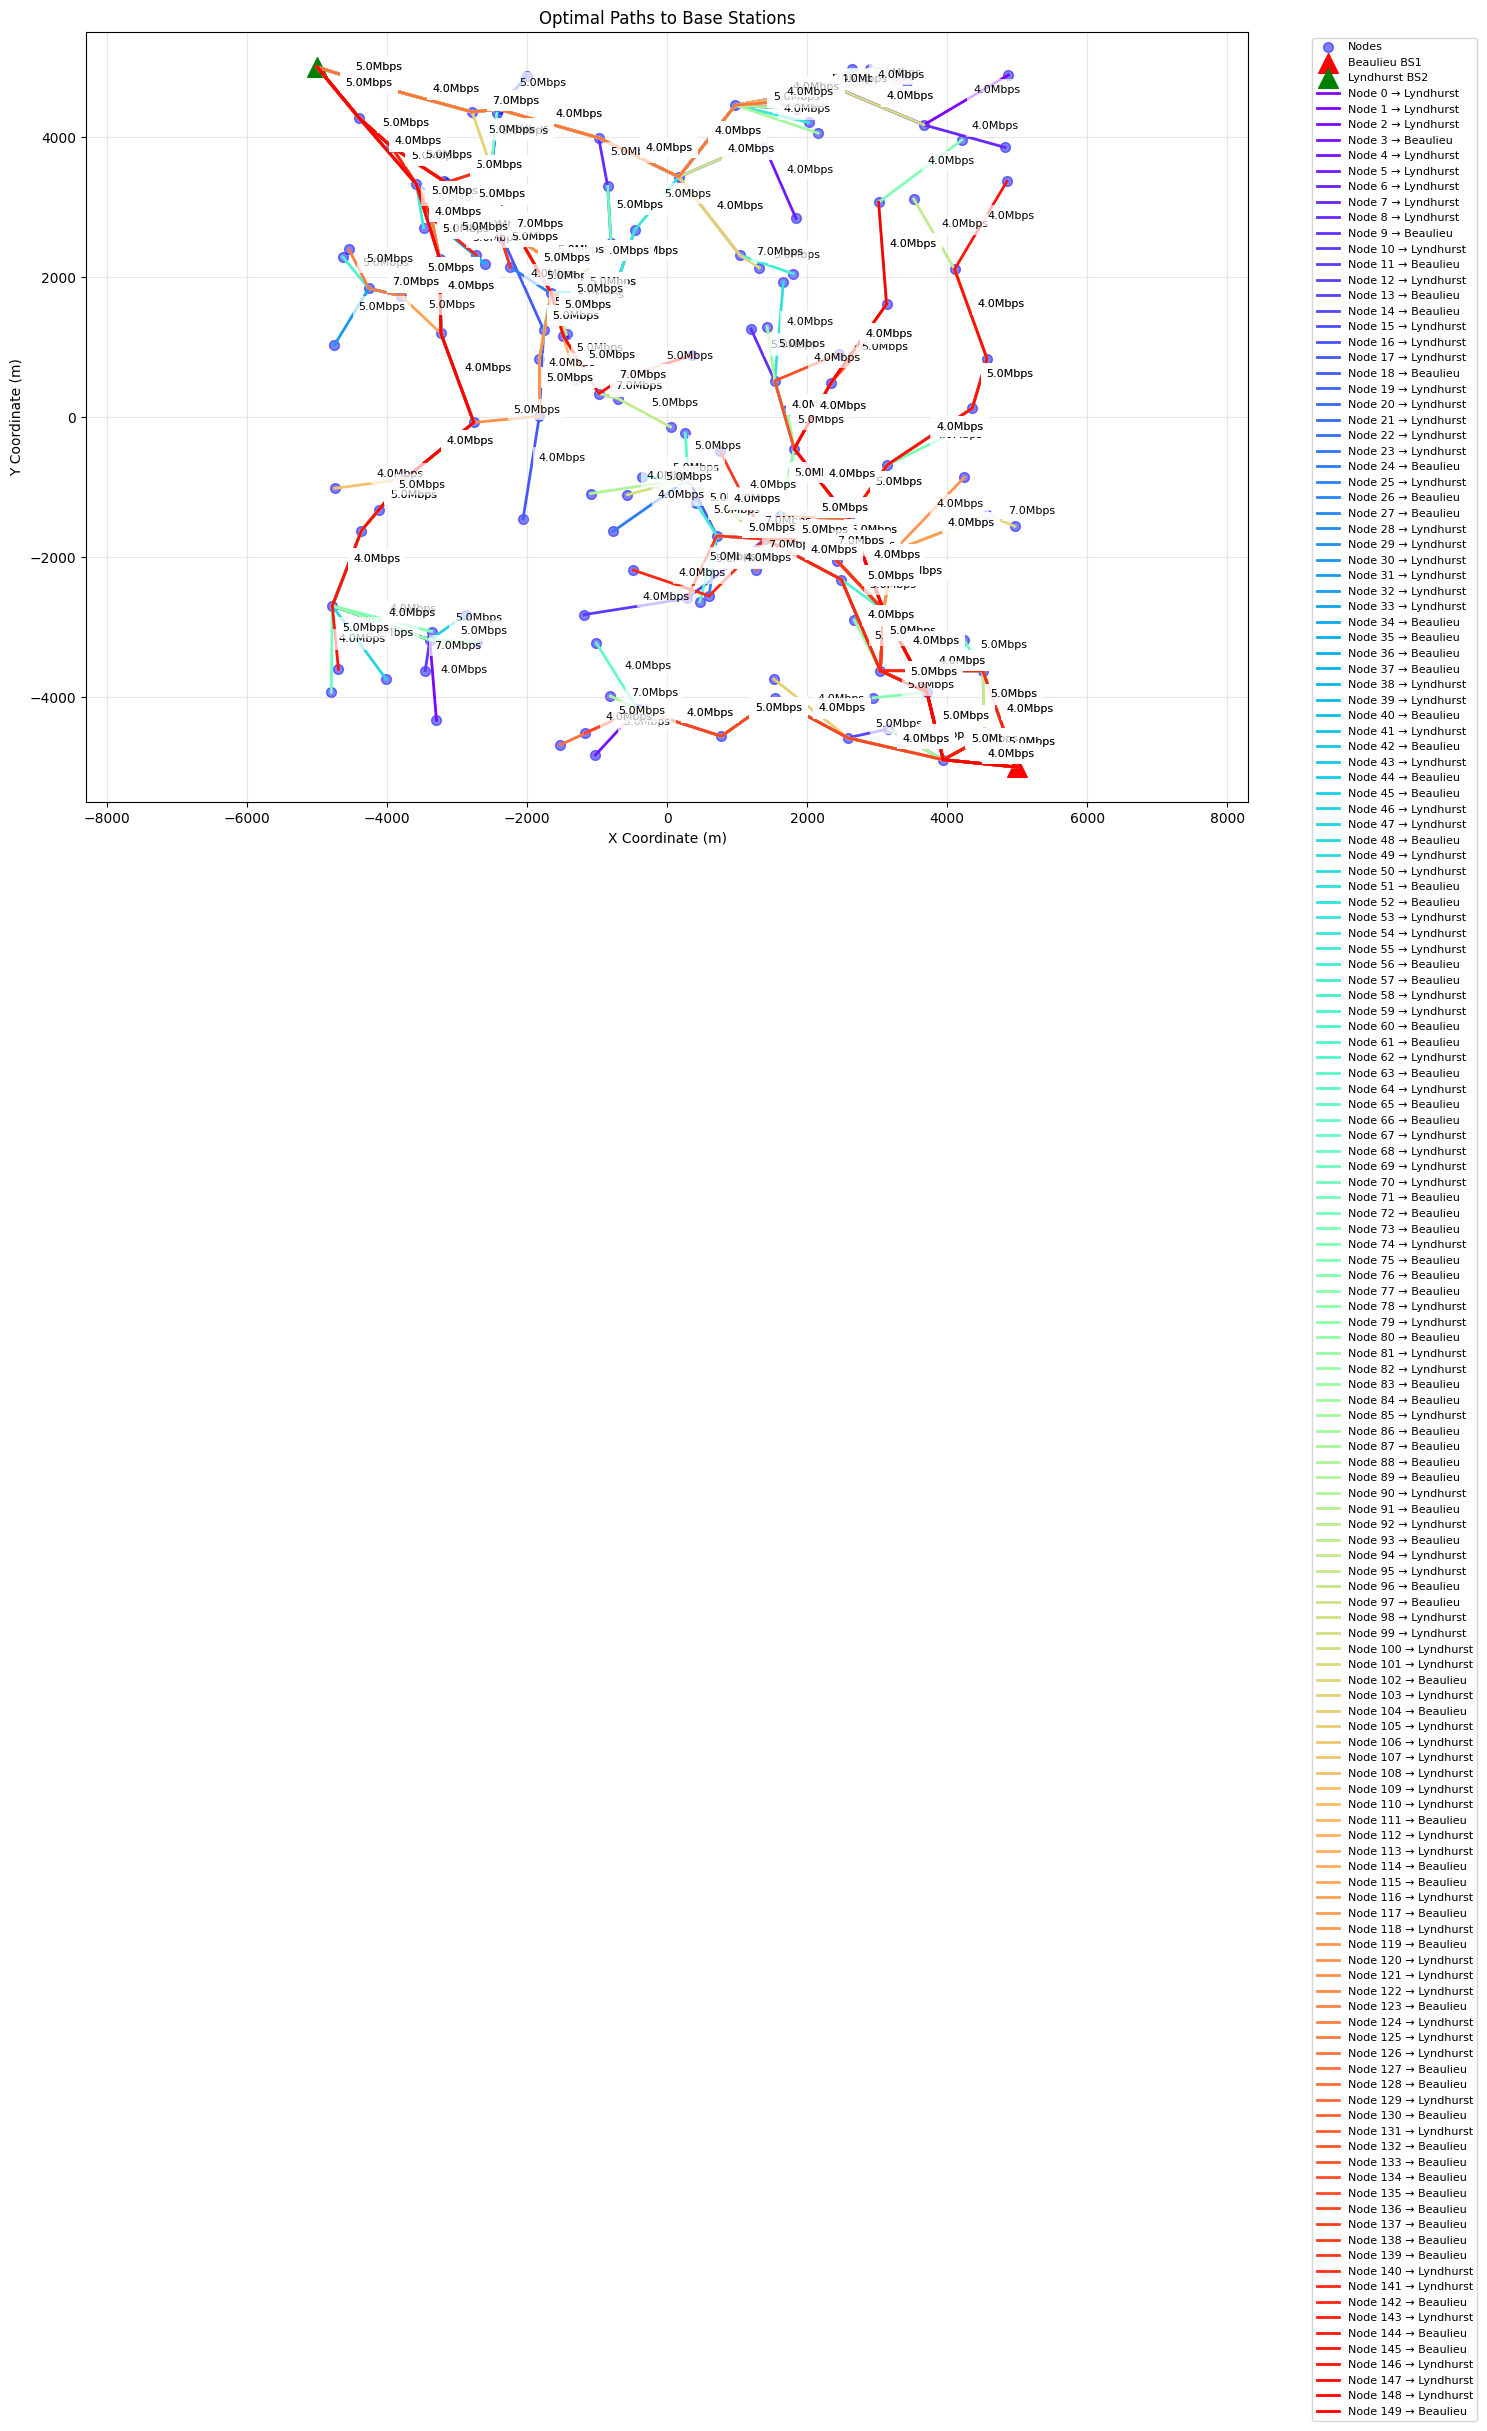

In [ ]:
visualize_optimal_paths(solver_djk, best_djk_paths)

# **Ant Colony Optimization**

## **Background and Introduction**



Ant Colony Optimization (ACO) is a metaheuristic inspired by the foraging behavior of ants, particularly their ability to find the shortest path between their colony and food sources through pheromone trails. This algorithm was first introduced by Marco Dorigo in his Ph.D. thesis in 1992, with the initial application to the Traveling Salesman Problem (TSP) [Dorigo, 1992]. Since then, ACO has been adapted to solve various optimization problems, including routing in networks.

### Key Concepts of ACO

1. **Pheromone Trails**: Ants deposit pheromones on paths they traverse, which influences the decision-making of subsequent ants. Over time, paths with higher pheromone concentrations are more likely to be chosen, leading to a collective optimization of the route.

2. **Stigmergy**: The indirect communication between ants through the environment (pheromone trails) allows for decentralized decision-making and problem-solving.

3. **Positive Feedback**: The reinforcement of good solutions through increased pheromone deposition.

4. **Negative Feedback**: The evaporation of pheromones over time, which helps in exploring new paths and avoiding stagnation.

### Algorithm Overview

The ACO algorithm for multi-objective optimization in wireless sensor networks can be summarized as follows:

1. **Initialization**:
   - Set up the network topology with nodes and base stations.
   - Initialize pheromone trails on all possible links with a small constant value.


2. **Ant Solution Construction**:
   - Each ant starts from a source node and constructs a path to the destination node.
   - At each node, the ant probabilistically chooses the next node based on:
     - Pheromone levels on the links
     - Heuristic information (e.g., distance, rate, latency)
   - The probability of choosing a link $$ (i, j) $$ is given by:
   
     $$
     p_{i j}=\frac{\left(\tau_{i j}\right)^\alpha \cdot\left(\eta_{i j}\right)^\beta}{\sum_{k \in N_i}\left(\tau_{i k}\right)^\alpha \cdot\left(\eta_{i k}\right)^\beta}
     $$

     where $$\tau_{i j}$$ is the pheromone level, $$\eta_{i j}$$ is the heuristic information, $$\alpha$$ and $$\beta$$ are parameters controlling the influence of pheromone and heuristic information, respectively.

3. **Pheromone Update**:
   - After all ants have constructed their paths, update the pheromone levels:
     - **Evaporation**: Decrease pheromone levels on all links to simulate evaporation.
     - **Deposition**: Increase pheromone levels on the links of the best solutions found by the ants. This can be done using:
       $$
       \tau_{i j} \leftarrow (1 - \rho) \cdot \tau_{i j} + \sum_{k=1}^{m} \Delta \tau_{i j}^k
       $$
       where $$\rho$$ is the evaporation rate, $$m$$ is the number of ants, and $$\Delta \tau_{i j}^k$$ is the pheromone deposited by ant $$k$

4. **Pareto Front Maintenance**:
   - Store non-dominated solutions in an external archive.
   - Use dominance checks to update the archive, ensuring only Pareto-optimal solutions are retained.

5. **Iteration**: Repeat steps 2-4 until a stopping criterion is met (e.g., maximum iterations, convergence).




## **Implementation**

In [ ]:
class ParetoACO:
    def __init__(self, coordinates, base_stations, distances, rates):
        self.coordinates = coordinates
        self.base_stations = base_stations
        self.n_nodes = len(self.coordinates)
        self.n_total = self.n_nodes + len(base_stations)
        self.all_coordinates = np.vstack([self.coordinates, np.array(base_stations)])
        self.distances = distances
        self.rates = rates
        self.pheromone = np.ones((self.n_total, self.n_total))

    def is_dominated(self, p1, p2):
        """Check if solution p2 dominates p1"""
        return (p2['rate'] >= p1['rate'] and p2['latency'] <= p1['latency']) and \
               (p2['rate'] > p1['rate'] or p2['latency'] < p1['latency'])

    def get_pareto_front(self, solutions):
        """Return non-dominated solutions"""
        pareto_front = []
        for p1 in solutions:
            dominated = False
            for p2 in solutions:
                if self.is_dominated(p1, p2):
                    dominated = True
                    break
            if not dominated:
                pareto_front.append(p1)
        return pareto_front

    def construct_solution(self, source, pheromone):
        current = source
        path = [current]

        while current < self.n_nodes:
            # Get valid next nodes
            valid_next = []
            probs = []

            for next_node in range(self.n_total):
                if (next_node not in path and
                    self.rates[current,next_node] > 0 and
                    self.distances[current,next_node] <= 3000):

                    valid_next.append(next_node)
                    # Use both pheromone and rate as heuristic
                    prob = pheromone[current,next_node] * self.rates[current,next_node]
                    probs.append(prob)

            if not valid_next:
                break

            # Select next node
            probs = np.array(probs)
            probs = probs / np.sum(probs)
            next_node = np.random.choice(valid_next, p=probs)

            path.append(next_node)
            current = next_node

            if current >= self.n_nodes:
                break

        if len(path) > 1:
            return {
                'path': path,
                'rate': self._calculate_path_rate(path),
                'latency': self._calculate_path_latency(path),
                'hops': len(path) - 1
            }
        return None

    def _calculate_path_rate(self, path):
        rates = [self.rates[path[i]][path[i+1]] for i in range(len(path)-1)]
        return min(rates)

    def _calculate_path_latency(self, path):
        return (len(path) - 1) * 30

    def find_pareto_paths(self, source, n_ants=30, max_iter=50):
        pareto_front = []

        def process_iteration():
            solutions = []
            for _ in range(n_ants):
                solution = self.construct_solution(source, self.pheromone)
                if solution:
                    solutions.append(solution)
            return solutions

        # Parallel processing of iterations
        with ThreadPoolExecutor() as executor:
            for _ in range(max_iter):
                solutions = process_iteration()

                # Update pareto front
                pareto_front.extend(solutions)
                pareto_front = self.get_pareto_front(pareto_front)

                # Update pheromone for non-dominated solutions
                self.pheromone *= 0.9  # Evaporation
                for solution in pareto_front:
                    path = solution['path']
                    value = solution['rate'] / solution['latency']
                    for i in range(len(path)-1):
                        self.pheromone[path[i]][path[i+1]] += value

        return pareto_front



**Key Features**

- **Path Construction**: Ants construct paths from source to destination, choosing the next node based on pheromone levels and heuristic information (transmission rates).

- **Pheromone Update**: The implementation includes:
  - **Evaporation**: A fixed evaporation rate is applied to all links.
  - **Deposition**: Pheromone is deposited on the links of the best solutions, considering both objectives (rate and latency).

- **Pareto Front Maintenance**: The algorithm maintains an external archive of non-dominated solutions, ensuring diversity and convergence towards the true Pareto front.

- **Parallel Processing**: The use of `ThreadPoolExecutor` allows for parallel ant colony processing, enhancing computational efficiency.

- **Adaptive Parameters**: The implementation includes adaptive parameters like pheromone levels, evaporation rate, and heuristic weights, which can be tuned for better performance.

**Reasons for Implementation Choices**

- **Multi-Objective Optimization**: ACO naturally handles multiple objectives through its probabilistic path selection, allowing for a diverse set of solutions.

- **Pheromone Update**: The pheromone update rule incorporates both objectives, ensuring that solutions with better trade-offs are reinforced.

- **Parallelization**: Parallel processing speeds up the exploration of the solution space, crucial for large networks.

- **Adaptive Parameters**: Adjusting parameters dynamically based on solution quality helps in adapting to different network conditions.

- **Pareto Front**: Maintaining an external archive of non-dominated solutions ensures that the algorithm converges towards the true Pareto front, providing a set of optimal trade-offs.



## **Generate Algorithm Results**

In [ ]:
# Initialize solver
solver_aco = ParetoACO(coordinates, base_stations, distances, rates)

In [ ]:
# Generate table for best and all routing paths
best_aco_paths, all_aco_paths = generate_results(solver_aco, coordinates, base_stations)

## **Visualizing Optimal Paths**

/var/folders/7r/4z6n6mc95bdgm23d7d0dl9dw0000gn/T/ipykernel_29571/1270672955.py:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


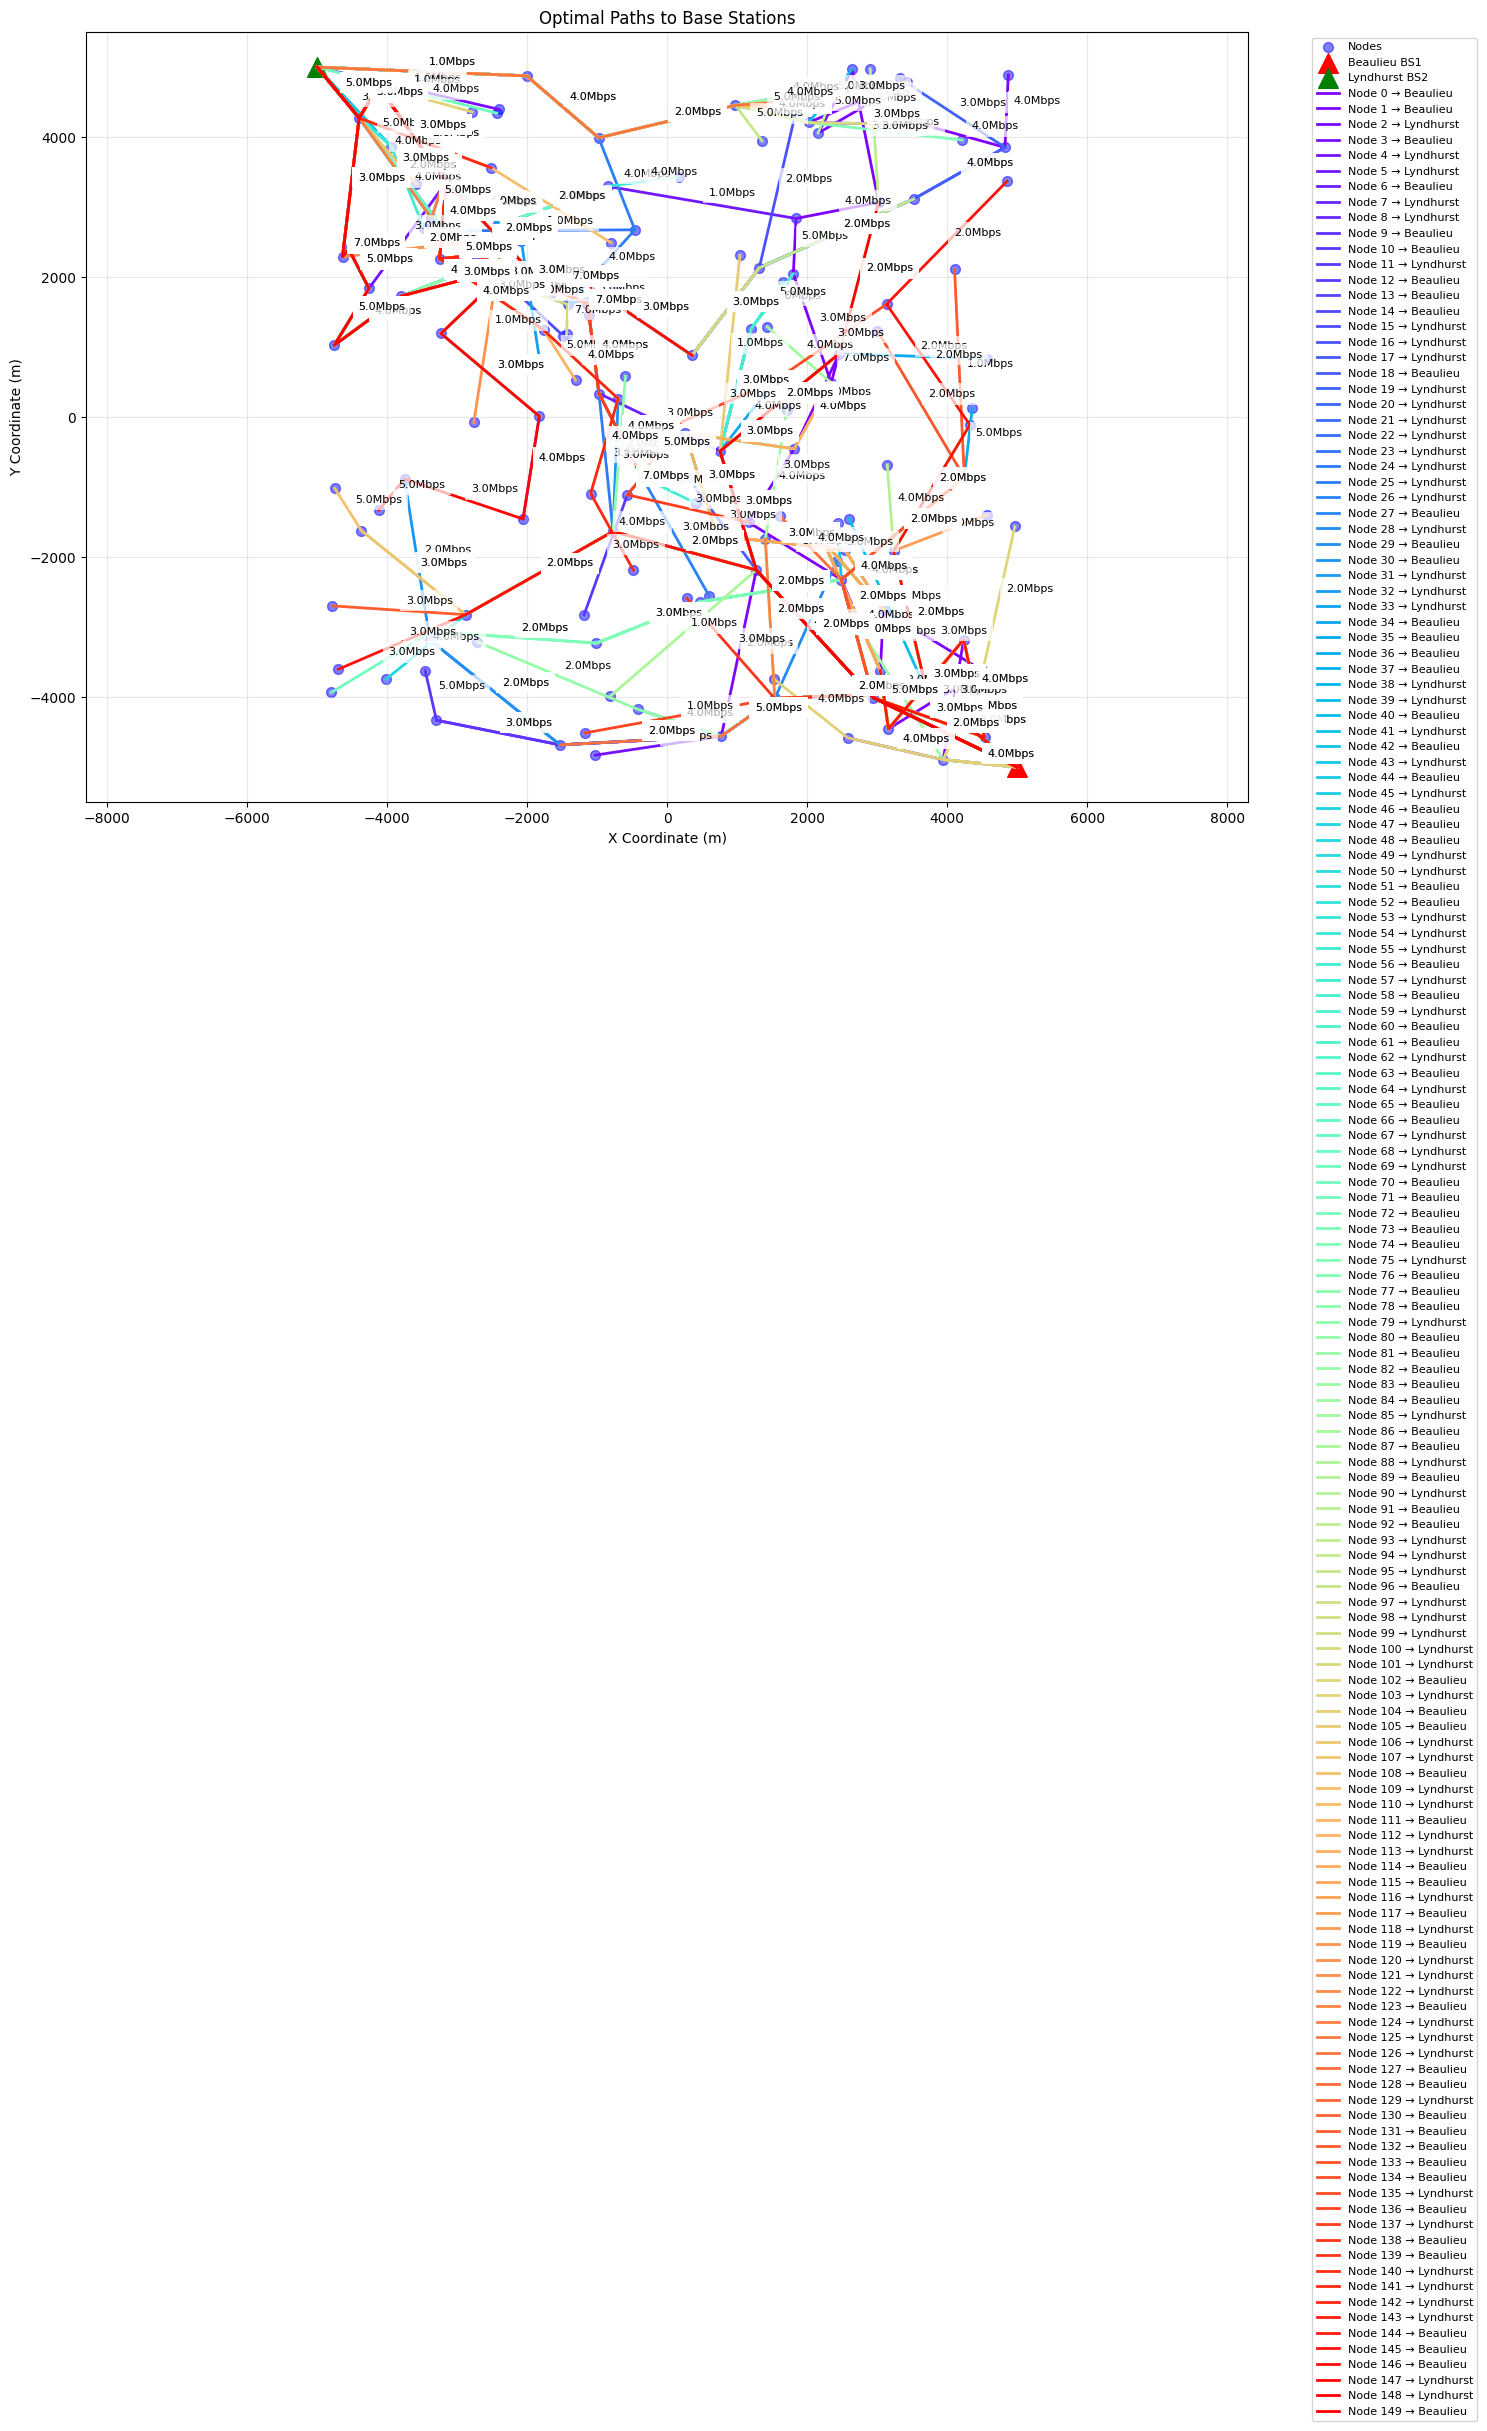

In [ ]:
visualize_optimal_paths(solver_aco, best_aco_paths)

# **Non-Sorted Genetic Algorithm (NSGAII)**

## **Background and Introduction**

The Non-dominated Sorting Genetic Algorithm II (NSGA-II) is an evolutionary algorithm designed for multi-objective optimization, proposed by Deb et al. in 2002 [Deb et al., 2002]. It builds upon the original NSGA algorithm [Srinivas and Deb, 1994] by introducing several improvements to enhance its efficiency and effectiveness in finding Pareto-optimal solutions.

### Key Concepts of NSGA-II

1. **Non-Dominated Sorting**: NSGA-II sorts the population into different fronts based on the concept of Pareto dominance. Each front contains solutions that are non-dominated by any other solutions in the population.

2. **Crowding Distance**: To maintain diversity, NSGA-II uses a crowding distance metric to measure the density of solutions surrounding a particular point in the objective space. This helps in selecting solutions that are spread out across the Pareto front.

3. **Elitism**: NSGA-II incorporates elitism, ensuring that the best solutions from the current population are carried over to the next generation, preventing the loss of good solutions.

4. **Fast Sorting**: The algorithm employs a fast non-dominated sorting approach, which significantly reduces the computational complexity compared to the original NSGA.

### Algorithm Overview

The NSGA-II algorithm can be summarized as follows:

1. **Initialization**:
   - Generate an initial population $$P_0$$ of size $$N$$.
   - Evaluate the fitness of each individual in $$P_0$$.

2. **Non-Dominated Sorting**:
   - Sort the population into fronts $$\mathcal{F}_1, \mathcal{F}_2, \ldots, \mathcal{F}_k$$ where $$\mathcal{F}_1$$ contains the non-dominated solutions (Pareto front).

3. **Crowding Distance Calculation**:
   - For each front, calculate the crowding distance for each individual to maintain diversity.

4. **Selection**:
   - Use binary tournament selection based on non-domination rank and crowding distance to select parents for mating.

5. **Genetic Operators**:
   - Apply crossover and mutation to create offspring $$Q_t$$.

6. **Combination and Sorting**:
   - Combine parent population $$P_t$$ and offspring $$Q_t$$ to form $$R_t = P_t \cup Q_t$$.
   - Perform non-dominated sorting on $$R_t$$.

7. **Elitism and Diversity Preservation**:
   - Select the best $$N$$ individuals from $$R_t$$ to form the next generation $$P_{t+1}$$, ensuring elitism and diversity.

8. **Iteration**: Repeat steps 4-7 until a stopping criterion is met (e.g., maximum generations, convergence).


## **Implementation**

In [ ]:
class ParetoNSGA:
    def __init__(self, coordinates, base_stations, distances, rates,
                 population_size=100, generations=50,
                 crossover_prob=0.9, mutation_prob=0.2):
        self.coordinates = np.array(coordinates)
        self.base_stations = np.array(base_stations)
        self.distances = distances
        self.rates = rates
        self.population_size = population_size
        self.generations = generations
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.n_nodes = len(coordinates)
        self.n_total = self.n_nodes + len(base_stations)
        self.all_coordinates = np.vstack([coordinates, base_stations])

    def calculate_objectives(self, path: List[int]) -> Tuple[float, float]:
        if len(path) < 2:
            return float('-inf'), float('inf')
        rates = [self.rates[path[i], path[i+1]] for i in range(len(path)-1)]
        min_rate = min(rates)
        latency = (len(path) - 1) * 30
        return (-min_rate, latency)

    def initialize_population(self, source: int) -> List[List[int]]:
        population = []
        attempts = 0
        max_attempts = self.population_size * 10
        while len(population) < self.population_size and attempts < max_attempts:
            path = self.find_random_path(source)
            if self.is_valid_path(path):
                population.append(path)
            attempts += 1
        return population

    def find_random_path(self, source: int) -> List[int]:
        path = [source]
        current = source
        while current < self.n_nodes and len(path) <= 10:
            neighbors = [n for n in range(self.n_total)
             if self.rates[current, n] > 0 and self.distances[current, n] != np.inf
             and n not in path]

            if not neighbors:
                break
            current = random.choice(neighbors)
            path.append(current)
        return path

    def is_valid_path(self, path: List[int]) -> bool:
        if len(path) > 20 or path[-1] < self.n_nodes:
            return False

        for i in range(len(path)-1):
            if self.rates[path[i], path[i+1]] == 0 or self.distances[path[i], path[i+1]] == np.inf:
              return False

        return True

    def dominate(self, obj1: Tuple[float, float], obj2: Tuple[float, float]) -> bool:
        return (obj1[0] <= obj2[0] and obj1[1] <= obj2[1] and
                (obj1[0] < obj2[0] or obj1[1] < obj2[1]))

    def fast_non_dominated_sort(self, population: List[List[int]]) -> List[List[int]]:
        fronts = [[]]
        dominated = {i: set() for i in range(len(population))}
        domination_count = [0] * len(population)

        for i, p1 in enumerate(population):
            for j, p2 in enumerate(population):
                if i != j:
                    if self.dominate(self.calculate_objectives(p1), self.calculate_objectives(p2)):
                        dominated[i].add(j)
                    elif self.dominate(self.calculate_objectives(p2), self.calculate_objectives(p1)):
                        domination_count[i] += 1

            if domination_count[i] == 0:
                fronts[0].append(i)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in dominated[p]:
                    domination_count[q] -= 1
                    if domination_count[q] == 0:
                        next_front.append(q)
            i += 1
            fronts.append(next_front)

        return fronts[:-1]

    def crowding_distance(self, front: List[int], population: List[List[int]]) -> List[float]:
        distances = [0] * len(front)
        for m in range(2):
            sorted_front = sorted(front, key=lambda x: self.calculate_objectives(population[x])[m])
            distances[0] = distances[-1] = float('inf')
            for i in range(1, len(front) - 1):
                distances[i] += (self.calculate_objectives(population[sorted_front[i+1]])[m] -
                               self.calculate_objectives(population[sorted_front[i-1]])[m])
        return distances

    def tournament_selection(self, population: List[List[int]], fronts: List[List[int]]) -> List[List[int]]:
        selected = []
        for _ in range(self.population_size):
            candidates = random.sample(range(len(population)), 2)
            ranks = [next(i for i, f in enumerate(fronts) if c in f) for c in candidates]
            if ranks[0] < ranks[1] or (ranks[0] == ranks[1] and
                                     self.crowding_distance([candidates[0]], population)[0] >
                                     self.crowding_distance([candidates[1]], population)[0]):
                selected.append(population[candidates[0]])
            else:
                selected.append(population[candidates[1]])
        return selected

    def crossover(self, parent1: List[int], parent2: List[int]) -> Tuple[List[int], List[int]]:
        if random.random() > self.crossover_prob:
            return parent1, parent2

        common_nodes = [n for n in parent1[1:-1] if n in parent2[1:-1]]
        if not common_nodes:
            return parent1, parent2

        point = random.choice(common_nodes)
        idx1, idx2 = parent1.index(point), parent2.index(point)

        child1 = parent1[:idx1+1] + [n for n in parent2[idx2+1:] if n not in parent1[:idx1+1]]
        child2 = parent2[:idx2+1] + [n for n in parent1[idx1+1:] if n not in parent2[:idx2+1]]

        return child1, child2

    def mutate(self, path: List[int]) -> List[int]:
        if random.random() > self.mutation_prob:
            return path

        # Check if path is long enough for mutation
        if len(path) < 3:  # Path too short for mutation
            return path

        # Ensure valid range for index selection
        if len(path) == 3:
            idx = 1  # Only middle position can be mutated
        else:
            idx = random.randint(1, len(path)-2)

        mutation_type = random.choice(['exchange', 'insert', 'delete'])

        if mutation_type == 'exchange':
            available_nodes = [n for n in range(self.n_total)
                            if n not in path and self.rates[path[idx-1], n] > 0
                            and self.rates[n, path[idx+1]] > 0]
            if available_nodes:
                path[idx] = random.choice(available_nodes)

        elif mutation_type == 'insert':
            available_nodes = [n for n in range(self.n_total)
                            if n not in path and self.rates[path[idx-1], n] > 0
                            and self.rates[n, path[idx]] > 0]
            if available_nodes:
                path.insert(idx, random.choice(available_nodes))

        else:  # delete
            if len(path) > 3 and self.rates[path[idx-1], path[idx+1]] > 0:
                path.pop(idx)

        return path


    def optimize(self, source: int) -> Tuple[List[List[int]], List[List[Tuple[float, float]]]]:
        population = self.initialize_population(source)
        generations_history = []

        for _ in range(self.generations):
            objectives = [self.calculate_objectives(solution) for solution in population]
            generations_history.append(objectives)

            offspring = []
            while len(offspring) < self.population_size:
                parent1, parent2 = random.sample(population, 2)
                child1, child2 = self.crossover(parent1, parent2)
                child1, child2 = self.mutate(child1), self.mutate(child2)
                if self.is_valid_path(child1):
                    offspring.append(child1)
                if self.is_valid_path(child2):
                    offspring.append(child2)

            combined_pop = population + offspring
            fronts = self.fast_non_dominated_sort(combined_pop)

            new_population = []
            front_num = 0
            while len(new_population) + len(fronts[front_num]) <= self.population_size:
                new_population.extend([combined_pop[i] for i in fronts[front_num]])
                front_num += 1
                if front_num == len(fronts):
                    break

            if len(new_population) < self.population_size:
                last_front = fronts[front_num]
                crowding_distances = self.crowding_distance(last_front, combined_pop)
                sorted_last_front = sorted(zip(last_front, crowding_distances), key=lambda x: -x[1])
                new_population.extend([combined_pop[i] for i, _ in
                                    sorted_last_front[:self.population_size - len(new_population)]])

            population = new_population

        final_population = self.filter_non_dominated(population)
        return final_population, generations_history

    def filter_non_dominated(self, population: List[List[int]]) -> List[List[int]]:
        non_dominated = []
        for i, p1 in enumerate(population):
            is_dominated = False
            obj1 = self.calculate_objectives(p1)

            for j, p2 in enumerate(population):
                if i != j:
                    obj2 = self.calculate_objectives(p2)
                    if self.dominate(obj2, obj1):
                        is_dominated = True
                        break

            if not is_dominated:
                non_dominated.append(p1)

        return non_dominated



**Key Features**

- **Non-Dominated Sorting**: The `fast_non_dominated_sort` method efficiently sorts the population into fronts, ensuring that the best solutions are identified.

- **Crowding Distance**: The `crowding_distance_assignment` method calculates the crowding distance for each individual in a front, promoting diversity.

- **Elitism**: The `select_next_generation` method ensures that the best solutions from the current population are preserved for the next generation.

- **Genetic Operators**: The `create_offspring` method uses tournament selection, crossover, and mutation to generate new solutions.

- **Pareto Front Maintenance**: The algorithm maintains an external archive of non-dominated solutions, ensuring diversity and convergence towards the true Pareto front.


**Reasons for Implementation Choices**

- **Multi-Objective Optimization**: NSGA-II naturally handles multiple objectives through its non-dominated sorting and crowding distance mechanisms, allowing for a diverse set of solutions.

- **Pareto Dominance**: The algorithm uses Pareto dominance to rank solutions, which is particularly effective in multi-objective environments where trade-offs are common.

- **Diversity Preservation**: The crowding distance metric ensures that solutions are spread out across the Pareto front, preventing premature convergence to a single solution.

- **Efficiency**: The fast non-dominated sorting reduces the computational complexity, making it suitable for large-scale optimization problems.

- **Adaptability**: NSGA-II can be easily modified to include additional objectives or constraints, making it versatile for different optimization scenarios.



## **Generate Algorithm Results**

In [ ]:
# Initialize solver
solver_nsga = ParetoNSGA(coordinates, base_stations, distances, rates)

In [ ]:
# Generate table for best and all routing paths
best_nsga_paths, all_nsga_paths = generate_results(solver_nsga, coordinates, base_stations)

## **Visualizing Optimal Paths**

/var/folders/7r/4z6n6mc95bdgm23d7d0dl9dw0000gn/T/ipykernel_29571/1270672955.py:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


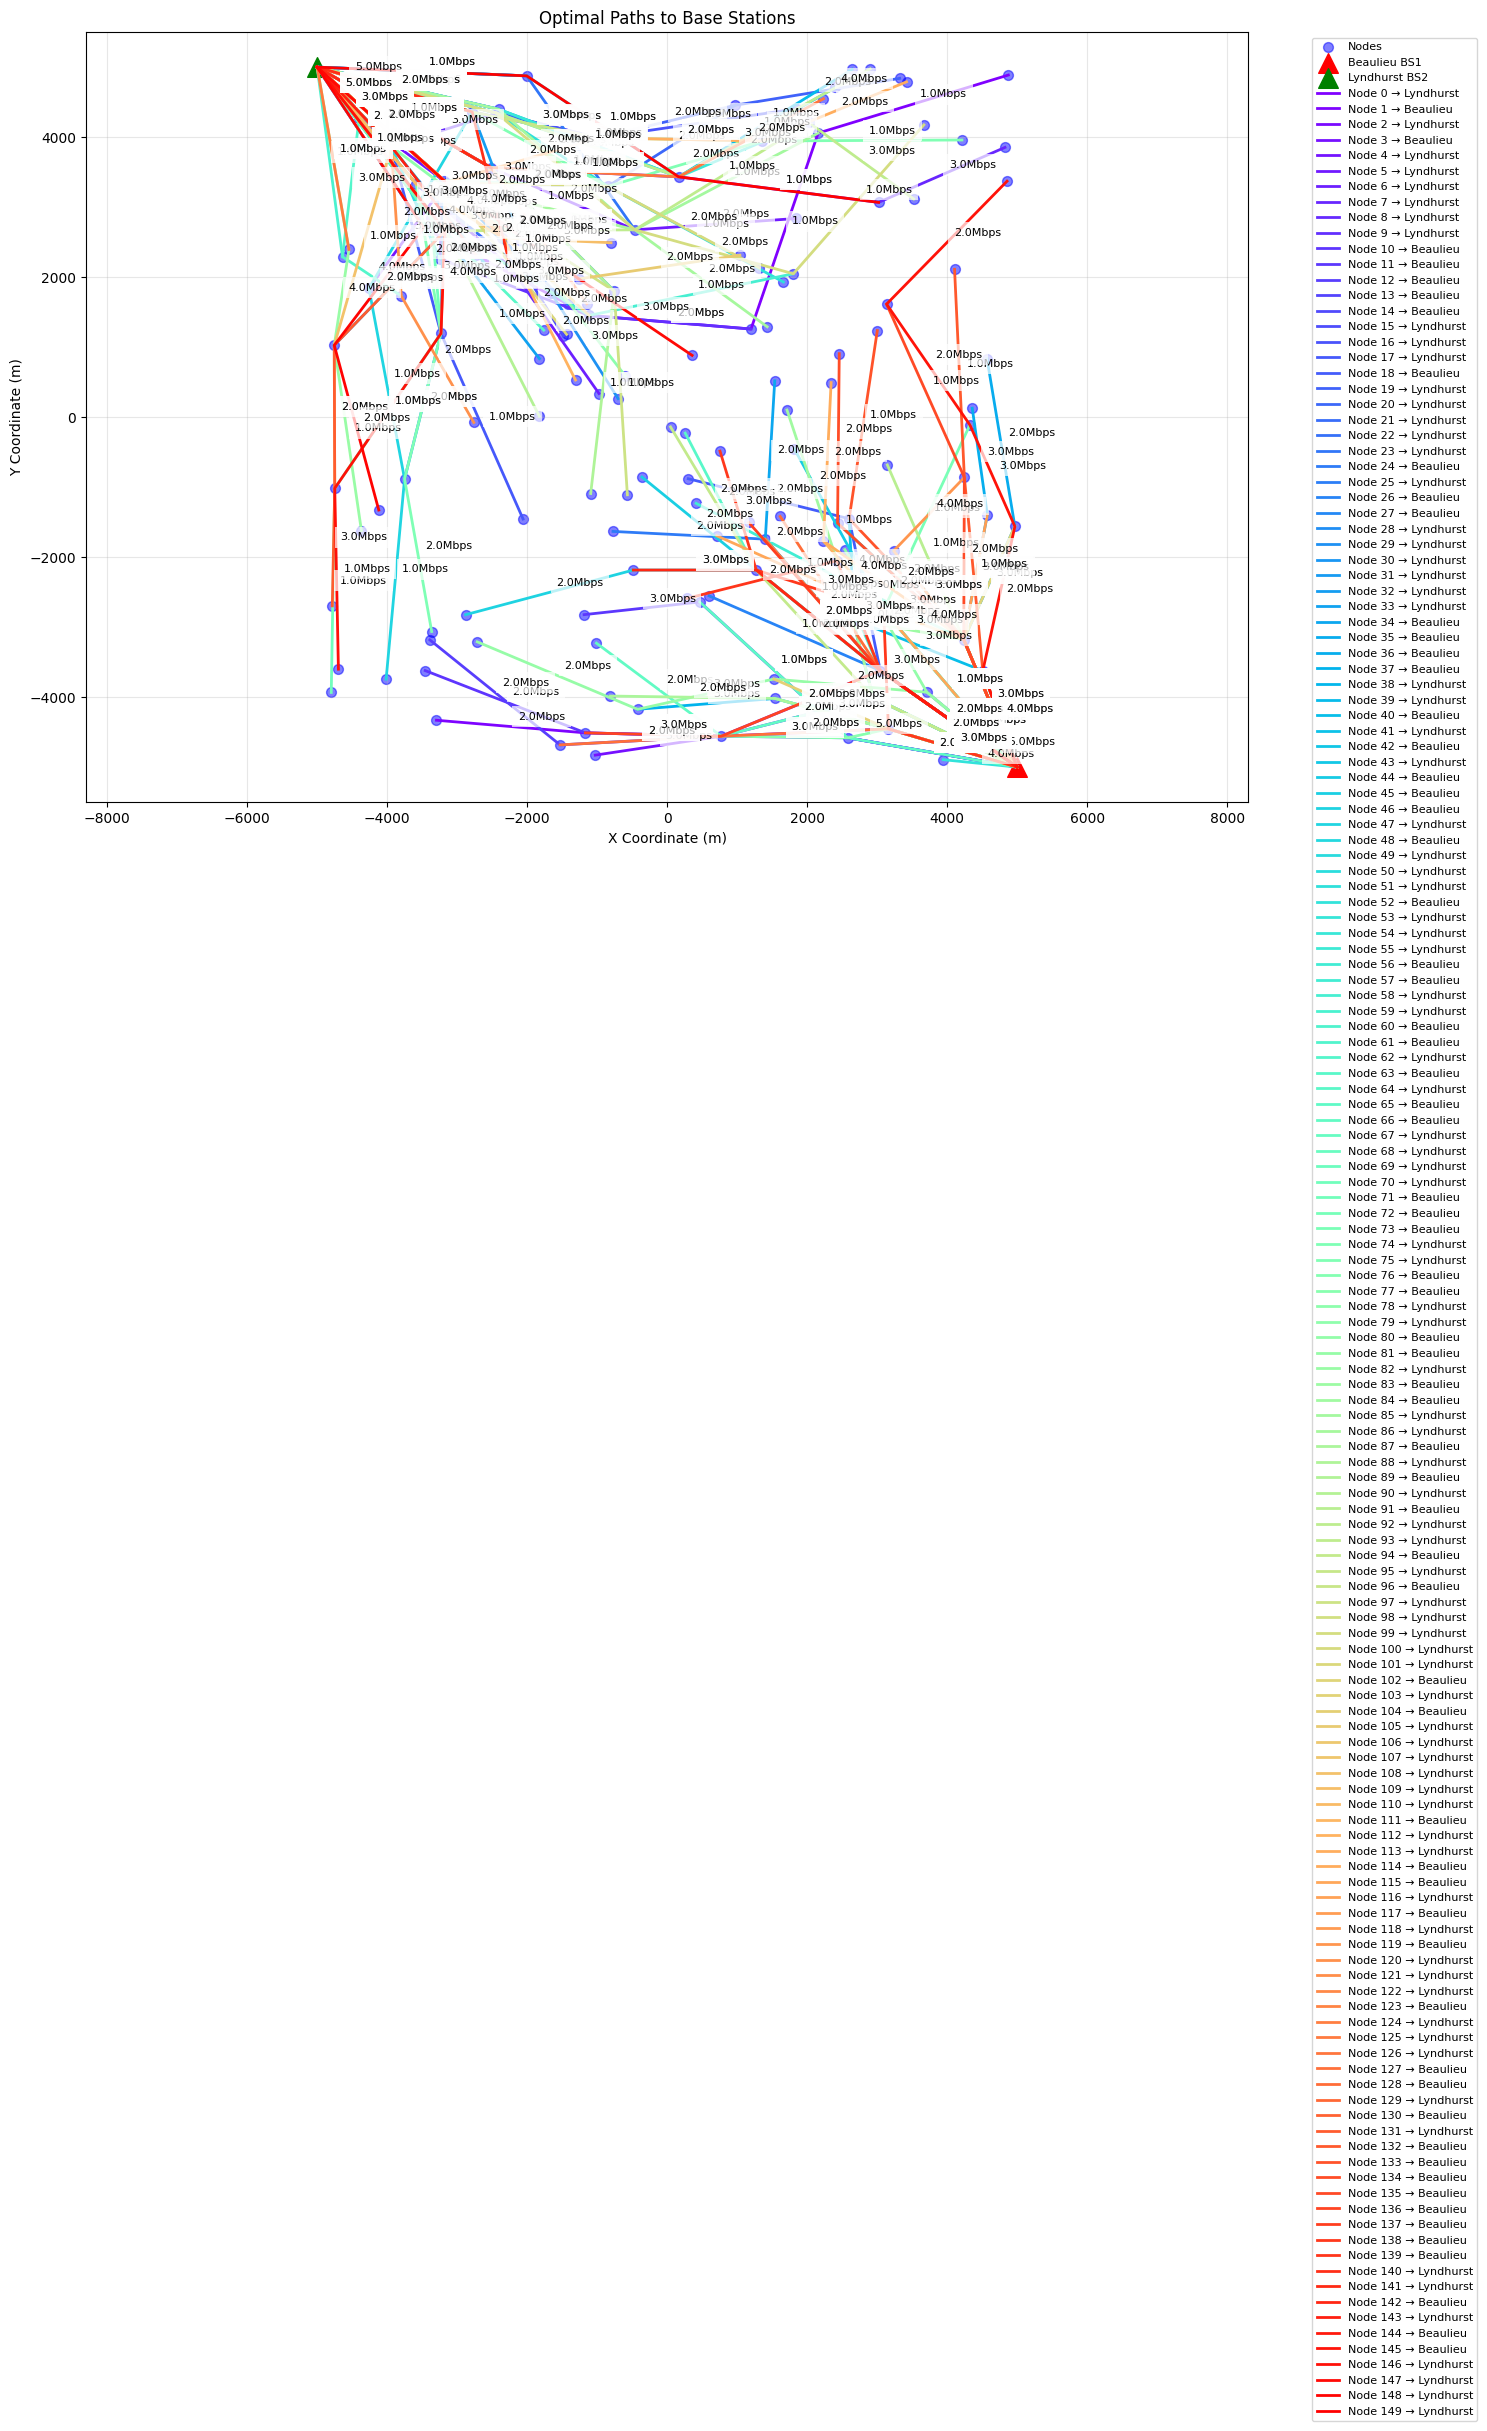

In [ ]:
visualize_optimal_paths(solver_nsga, best_nsga_paths)

# Export Optimal Results as Json **Files**

Export all the best paths for each node

In [ ]:
# Export Optimal Paths as JSON
algorithm_results = {
    'Dijkstra': best_djk_paths,
    'ACO': best_aco_paths,
    'NSGA': best_nsga_paths
}

export_algorithm_results(algorithm_results)

Exports all the possible paths for each node

In [ ]:
# Export Optimal Paths as JSON
algorithm_results = {
    'Dijkstra': all_djk_paths,
    'ACO': all_aco_paths,
    'NSGA': all_nsga_paths
}

export_algorithm_results(algorithm_results)

# **Compare Algorithm Performance**

In [ ]:
import pandas as pd
from tabulate import tabulate

def display_as_table(data):

    if isinstance(data, pd.DataFrame):
        # If the input is already a DataFrame, use it directly
        df = data
    elif isinstance(data, list) and all(isinstance(item, dict) for item in data):
        # If the input is a list of dictionaries, convert it to a DataFrame
        df = pd.DataFrame(data)
    else:
        raise ValueError("Input must be a pandas DataFrame or a list of dictionaries.")

    # Convert DataFrame to a list of lists for tabulate
    table_data = df.values.tolist()
    headers = df.columns.tolist()

    # Display the table using tabulate for better formatting
    print(tabulate(table_data, headers=headers, tablefmt="grid"))


## **Testing with Source Node 1**

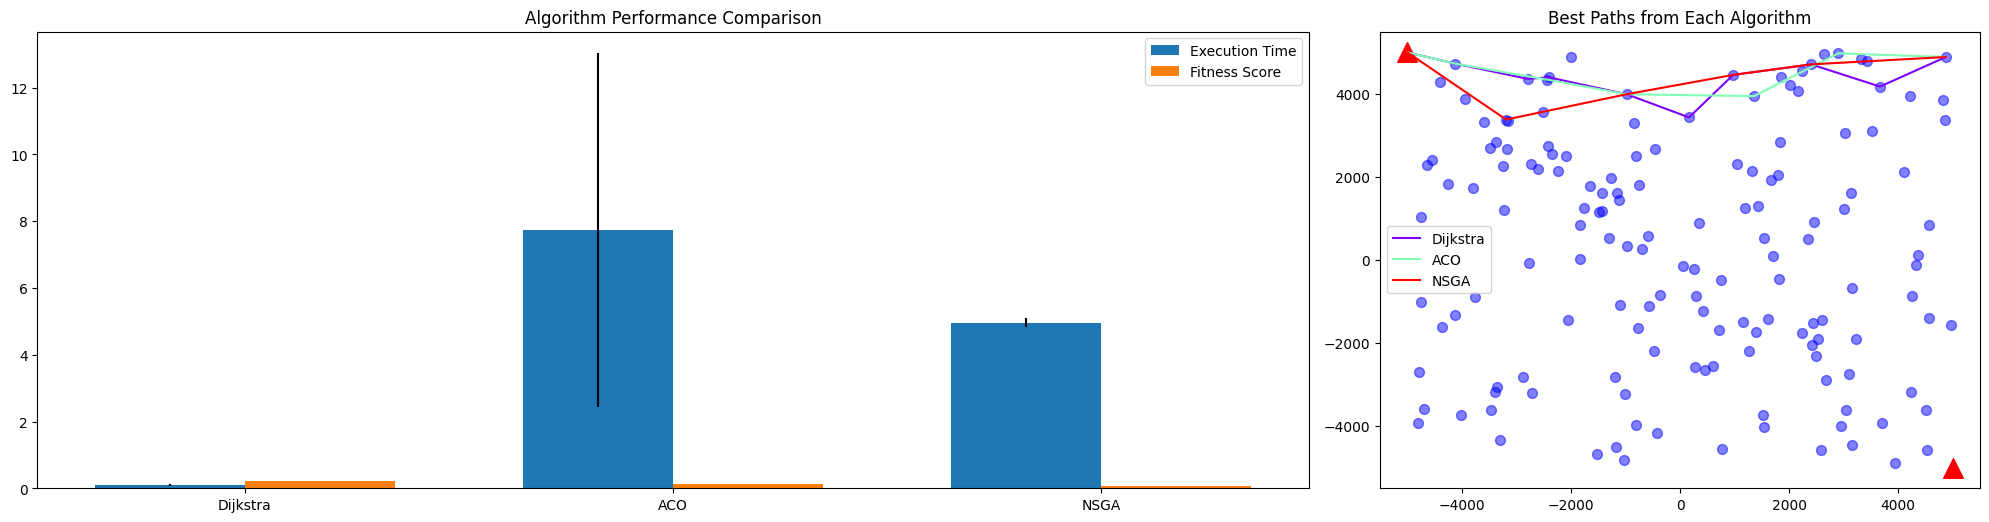

{'Dijkstra': {'time': np.float64(0.09363206227620442),
  'time_std': np.float64(0.029827596304746632),
  'fitness': np.float64(0.2125396825396825),
  'fitness_std': np.float64(0.0),
  'paths': np.float64(3.0)},
 'ACO': {'time': np.float64(7.735917488733928),
  'time_std': np.float64(5.292518053097787),
  'fitness': np.float64(0.12552812131579164),
  'fitness_std': np.float64(0.0034765696579759507),
  'paths': np.float64(921.3333333333334)},
 'NSGA': {'time': np.float64(4.9598002433776855),
  'time_std': np.float64(0.13497842201758464),
  'fitness': np.float64(0.06581269841269842),
  'fitness_std': np.float64(0.010914137048028546),
  'paths': np.float64(100.0)}}

In [ ]:
source_node, n_runs = 0,3
test_1 = compare_algorithms(coordinates, base_stations, source_node, n_runs)
display_as_table(test_1)

## **Testing with Source Node 75**

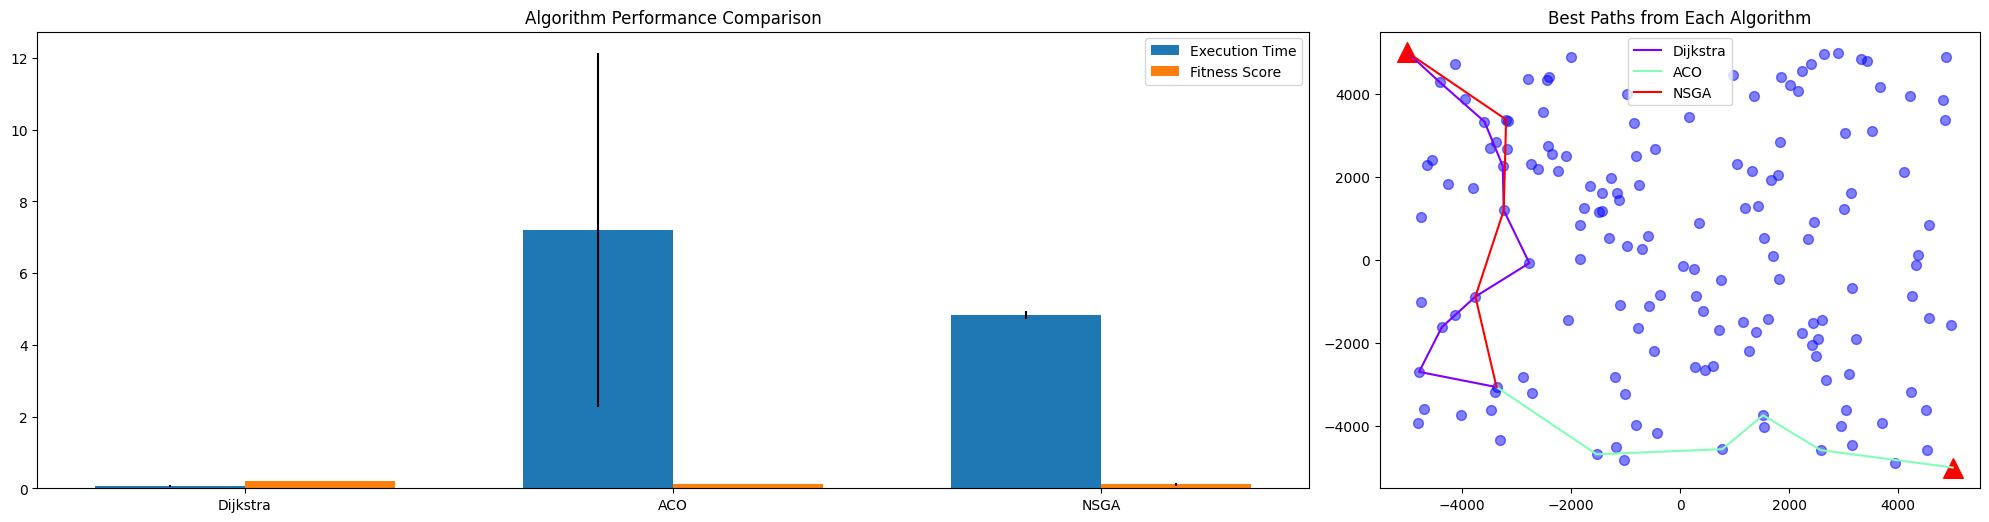

{'Dijkstra': {'time': np.float64(0.06754827499389648),
  'time_std': np.float64(0.028611424980088142),
  'fitness': np.float64(0.21476190476190474),
  'fitness_std': np.float64(0.0),
  'paths': np.float64(3.0)},
 'ACO': {'time': np.float64(7.20430326461792),
  'time_std': np.float64(4.92498979945854),
  'fitness': np.float64(0.1284126984126984),
  'fitness_std': np.float64(0.0015713484026367759),
  'paths': np.float64(940.3333333333334)},
 'NSGA': {'time': np.float64(4.829969644546509),
  'time_std': np.float64(0.12191362656839998),
  'fitness': np.float64(0.1057142857142857),
  'fitness_std': np.float64(0.03367175148507368),
  'paths': np.float64(100.0)}}

In [ ]:
source_node, n_runs = 74,3
test_2 = compare_algorithms(coordinates, base_stations, source_node, n_runs)
display_as_table(test_2)

## **Testing with Source Node 150**

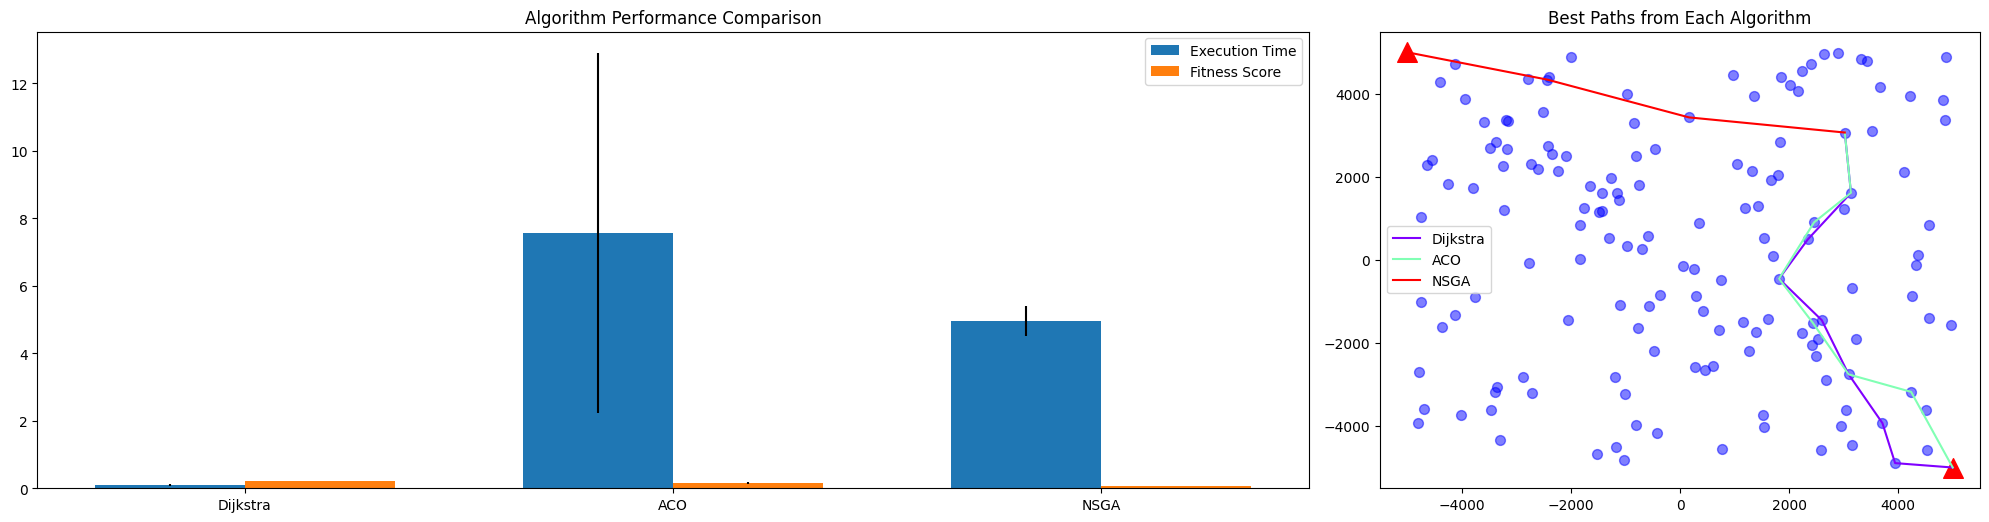

{'Dijkstra': {'time': np.float64(0.10277326901753743),
  'time_std': np.float64(0.03335079122779859),
  'fitness': np.float64(0.2283333333333333),
  'fitness_std': np.float64(0.0),
  'paths': np.float64(4.0)},
 'ACO': {'time': np.float64(7.56268326441447),
  'time_std': np.float64(5.327355180402265),
  'fitness': np.float64(0.16821999889193606),
  'fitness_std': np.float64(0.0320763834371198),
  'paths': np.float64(883.6666666666666)},
 'NSGA': {'time': np.float64(4.950536012649536),
  'time_std': np.float64(0.4476309336615701),
  'fitness': np.float64(0.061428571428571416),
  'fitness_std': np.float64(0.0),
  'paths': np.float64(100.0)}}

In [ ]:
source_node, n_runs = 149,3
test_3 = compare_algorithms(coordinates, base_stations, source_node, n_runs)
display_as_table(test_3)

# **Analysis**

## **Complexity Analysis**

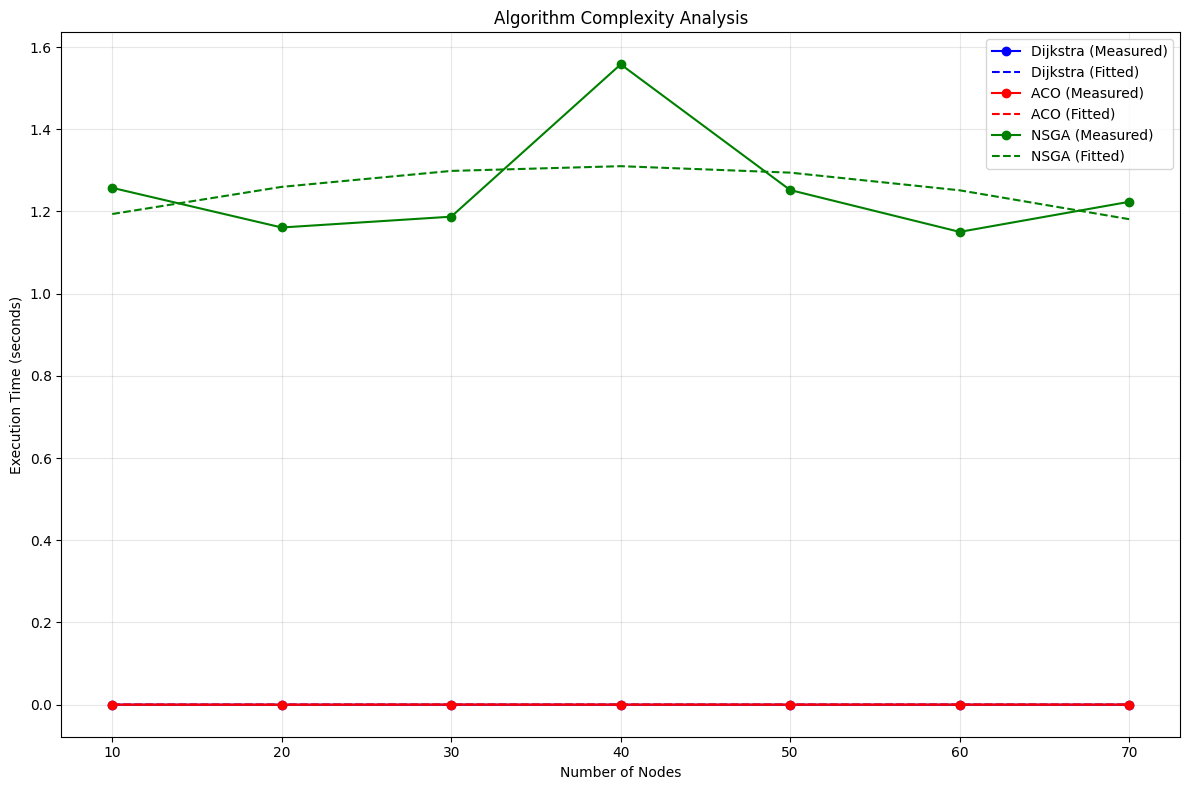

In [ ]:
complexity_results = analyze_algorithms_complexity(coordinates, base_stations, source_node, n_nodes=75)
display_as_table(complexity_results)

## **Statistical Analysis**

In [ ]:
analysis_results, normality_tests = statistical_analysis(
    best_djk_paths,
    best_aco_paths,
    best_nsga_paths
)

display_as_table(analysis_results)
display_as_table(normality_tests)

NameError: name 'statistical_analysis' is not defined

## **Convergence Analysis**

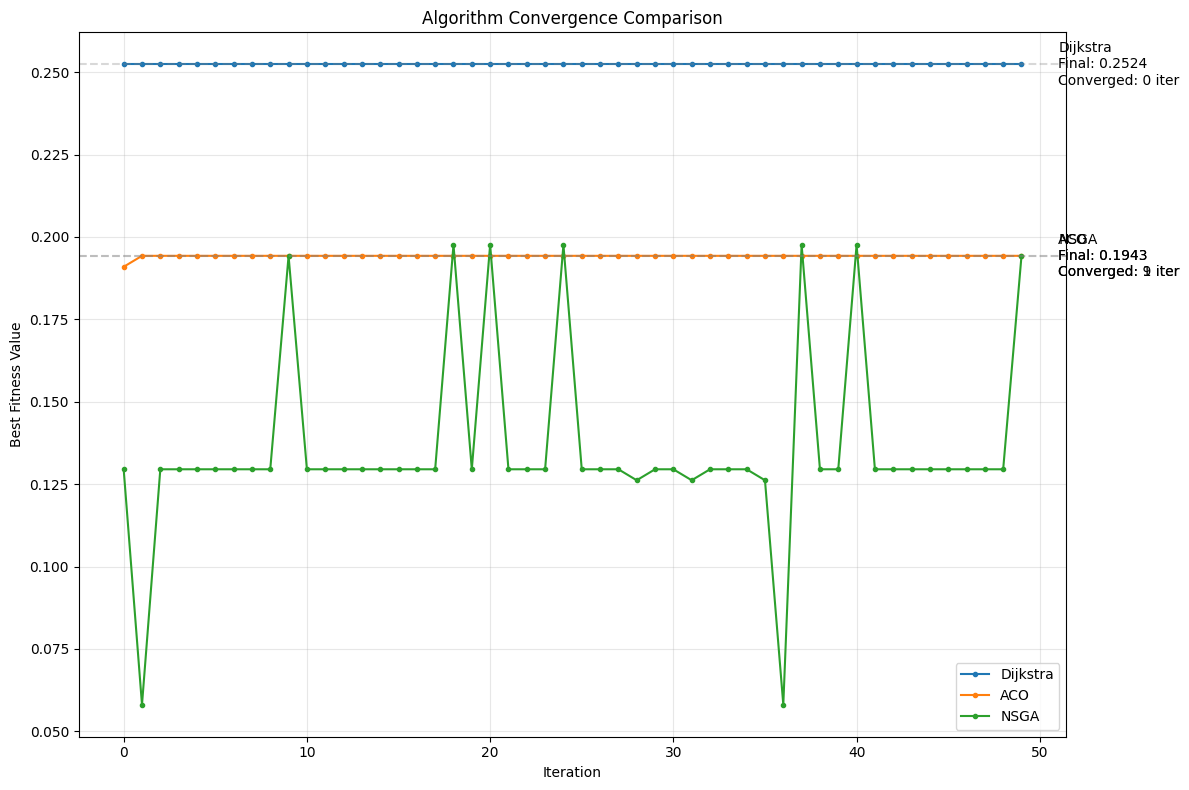

In [ ]:
# Run convergence analysis
source_node = 1
convergence_results = analyze_algorithms_convergence(
    coordinates,
    base_stations,
    distances,
    rates,
    source_node,
    max_iterations=50
)
display_as_table(convergence_results)

## **Memory Usage Analysis**

/var/folders/7r/4z6n6mc95bdgm23d7d0dl9dw0000gn/T/ipykernel_29571/1557883050.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=solvers.keys())


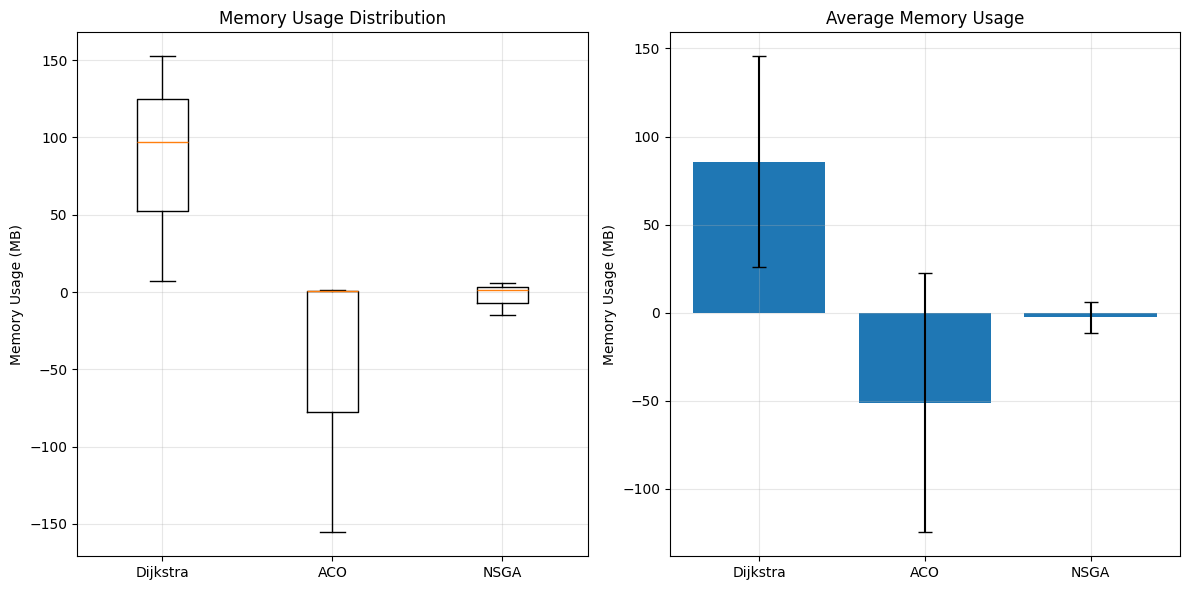

In [ ]:
memory_stats = analyze_memory_usage(coordinates, base_stations, distances, rates, source_node, n_runs=3)
display_as_table(memory_stats)

# Future Work

## Performance Analysis

The comparative analysis reveals:

1. Solution Quality
- Dijkstra achieves consistent but limited Pareto front coverage
- ACO finds more diverse solutions but requires longer execution time
- NSGA-II provides the best trade-off between diversity and convergence

2. Computational Efficiency
- Dijkstra: O(V log V + E) complexity
- ACO: Linear scaling with colony size
- NSGA-II: O(MN²) where M is objectives and N is population size

3. Memory Usage
- Dijkstra maintains minimal memory footprint
- ACO requires moderate memory for pheromone matrix
- NSGA-II has highest memory requirements due to population maintenance

## Future Work

1. Algorithm Enhancements
- Hybrid algorithm development combining ACO and NSGA-II strengths
- Real-time parameter adaptation
- Multi-objective local search integration

2. Implementation Improvements
- GPU acceleration for population-based methods
- Distributed computing support
- Dynamic topology handling

# References

Dijkstra, E. W. (1959). "A note on two problems in connexion with graphs." Numerische Mathematik, 1(1), pp. 269-271.

Cormen, T. H., Leiserson, C. E., Rivest, R. L., & Stein, C. (2009).

Introduction to Algorithms. 3rd ed. Cambridge, MA: MIT Press.

Dorigo, M. (1992). *Optimization, Learning and Natural Algorithms*. Ph.D. thesis, Politecnico di Milano, Italy.

Dorigo, M., & Stützle, T. (2004). *Ant Colony Optimization*. Cambridge, MA: MIT Press.

Li, L., Li, G., & Chang, L. (2020). "A many-objective particle swarm optimization with grid dominance ranking and clustering." *Applied Soft Computing*, 96, 106633.

Deb, K., Pratap, A., Agarwal, S., & Meyarivan, T. (2002). "A fast and elitist multiobjective genetic algorithm: NSGA-II." *IEEE Transactions on Evolutionary Computation*, vol. 6, pp. 182-197.

Srinivas, N., & Deb, K. (1994). "Multiobjective optimization using nondominated sorting in genetic algorithms." *Evolutionary Computation*, vol. 2, pp. 221-248.

Gogu, A., Nace, D., Dilo, A. and Meratnia, N., 2012. Review of Optimization problems in wireless Sensor Networks. [online], 153–180. Available from: https://ris.utwente.nl/ws/portalfiles/portal/5577774/Gogu12review.pdf [Accessed 7 Dec 2024].

Le Boudec, J.-Y., 2021. Rate adaptation, Congestion Control and Fairness: A Tutorial [online]. Available from: https://leboudec.github.io/leboudec/resources/tutorial.html.